## 1. Introduction
### Project Overview
With the increasing global waste generation, the need for effective dumpsite management by governments and society is becoming more critical. However, governments often face significant challenges in managing illegal dumpsites, including timely monitoring, high labor costs, and economic burdens.
This notebook demonstrates the development of the automated dumpsite detection method using object detection algorithms. The goal is to efficiently detect both large dumpsites and smaller, harder-to-track dumpsites.

### Motivation
Object detection algorithms enable significant savings in both time and labor.
The improved monitoring systems can get the useful information of dumpsites swiftly:
Help city managers to get the information of dumps in time, resulting in a better management decision.
    
### Problem Statement
Unlike traditional approaches that rely on manually marking dumpsite boundaries, this project leverages advanced technologies to improve efficiency and accuracy.
- Environmental Challenges
    Rapid global development has increased the need for effective dumpsite monitoring and management to mitigate environmental impacts.
- Manual Detection Issues
    Currently, local authorities and environmental agencies face difficulties in promptly detecting illegal dumpsites, leading to inefficient waste management.
- Resource Intensive
    The World Bank emphasizes that large amounts of labor and financial resources are required to manually identify and monitor dumpsites, adding significant costs.


In [1]:
conda info --env

# conda environments:
#
Amber21                  /home/sqs/.conda/envs/Amber21
dolores               *  /home/sqs/.conda/envs/dolores
gmx-mmpbsa               /home/sqs/.conda/envs/gmx-mmpbsa
                         /home/sqs/amber24_src/build/CMakeFiles/miniconda/install
base                     /opt/miniconda3
DeepPROTACs              /opt/miniconda3/envs/DeepPROTACs
PyAutoFEP                /opt/miniconda3/envs/PyAutoFEP
af2                      /opt/miniconda3/envs/af2
karmadock                /opt/miniconda3/envs/karmadock
pytorch                  /opt/miniconda3/envs/pytorch
reinvent.v3.2            /opt/miniconda3/envs/reinvent.v3.2


Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import xml.etree.ElementTree as ET
# from ultralytics import YOLO
from collections import defaultdict, Counter
import json
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler, random_split, Subset
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import random
from albumentations import Compose, HueSaturationValue, GaussianBlur, ShiftScaleRotate, HorizontalFlip, VerticalFlip, Rotate, RandomBrightnessContrast, Normalize, ElasticTransform, ColorJitter, BboxParams
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
from copy import deepcopy
import matplotlib.patches as patches
import torchvision.transforms as T
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
import yaml
import torch.nn.functional as F
import datetime

ModuleNotFoundError: No module named 'imblearn'

In [2]:
os.getcwd()

'/home/sqs/dolores'

## 2. Data Sources
- Our dataset is from ScienceDB (scidb.cn), the url is : https://www.scidb.cn/en/s/6bq2M3</br>

- Datasets are in PASCAL VOC format</br>
- To facilitate uniform data reading, we point the current working directory to `/root` </br>
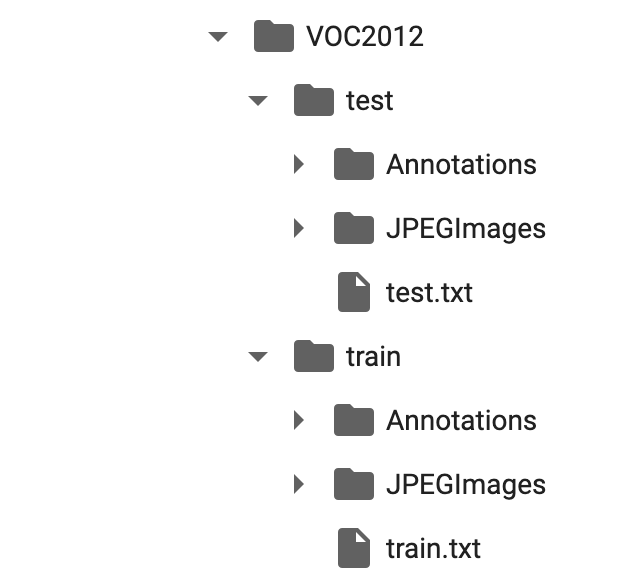

In [13]:
# convert annotation files to find How many labels are there
# Define the labels to be ignored
ignored_labels = {'mining waste', 'industry waste'}

def convert_annotation_find_labels(path, txt_file_path):
  labels = []

  with open(txt_file_path, 'r') as f:
      image_prefixes = f.read().strip().splitlines()
  updated_prefixes = []

  for each_xml in os.listdir(path):
      pic_xml = os.path.join(path, each_xml)
      tree = ET.parse(pic_xml)
      root = tree.getroot()
      objects = root.findall('object')

      # Filter out ignored tags
      objects_to_remove = [obj for obj in objects if obj.find('name').text in ignored_labels]
      for obj in objects_to_remove:
          root.remove(obj)

      # If there are no objects remaining, delete the corresponding image and comment files
      if not root.findall('object'):
          # Get image file name
          image_id = each_xml[:-4]  # Remove the .xml suffix
          img_path = os.path.join(path.replace('Annotations', 'JPEGImages'), image_id + '.jpg')

          # dele image files
          if os.path.exists(img_path):
              os.remove(img_path)
          # dele xml files
          os.remove(pic_xml)
      # Remove from the list of txt file prefixes
          if image_id in image_prefixes:
              image_prefixes.remove(image_id)
      else:
          # If there are remaining objects, save the modified comment file
          tree.write(pic_xml)

          # Collect the remaining labels
          for ele in root.findall('object'):
              label = ele.find('name').text
              labels.append(label)

          # Preserve valid image prefixes
          image_id = each_xml[:-4]
          if image_id in image_prefixes:
              updated_prefixes.append(image_id)

  # Update and save the new prefix list to a txt file
  with open(txt_file_path, 'w') as f:
    f.write('\n'.join(updated_prefixes))

  set_labels = set(labels)
  print(path, set_labels)
  return labels

train_object_labels = convert_annotation_find_labels('VOC2012/train/Annotations', 'VOC2012/train/train.txt')
test_object_labels = convert_annotation_find_labels('VOC2012/test/Annotations', 'VOC2012/test/test.txt')

VOC2012/train/Annotations {'agriculture forestry', 'disposed garbage', 'construction waste', 'domestic garbage'}
VOC2012/test/Annotations {'disposed garbage', 'construction waste', 'agriculture forestry', 'domestic garbage'}


In [3]:
with open('./label_map.json', 'r') as json_file:
  label_map = json.load(json_file)
label_name = {v : k for k, v in label_map.items()}

In [ ]:
## 3. Exploratory Analysis of Data

In [15]:
# Number of statistics for each label
name_number = defaultdict(int)
for index, class_name in enumerate(train_object_labels):
  name_number[label_map[class_name]] += 1
  train_object_labels[index] = label_map[class_name]
# print('train_object_labels', train_object_labels)

In [16]:
df = pd.Series(data=name_number.values(), index=list(label_name[name] for name in name_number.keys()), name="train_labels_distribution")
df

domestic garbage        2301
construction waste       581
agriculture forestry     247
disposed garbage           9
Name: train_labels_distribution, dtype: int64

### 3.1 Calculation of category weights based on imbalances

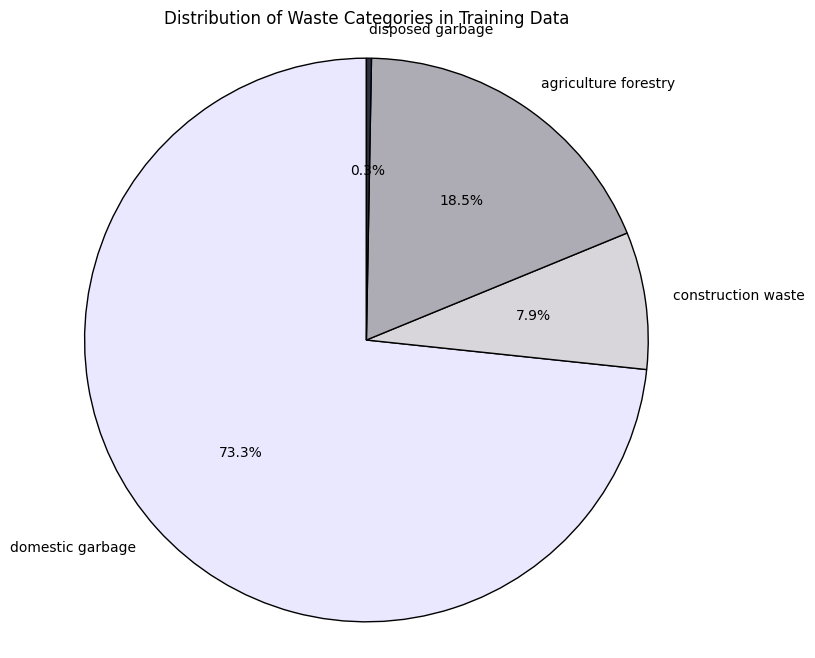

In [17]:
# Percentage of each category of visualization
# Create a pie chart
plt.figure(figsize=(8, 8))  # Optional: to make the pie chart bigger

plt.pie([2301, 247, 581, 9],
    labels=list(label_name[name] for name in name_number.keys()),
    autopct='%1.1f%%',  # Display percentage with one decimal place
    startangle=90,      # Rotate the start of the pie chart
    wedgeprops={'edgecolor': 'black'},  # Add border to slices for clarity
    colors=['#EAE8FF','#D8D5DB','#ADACB5','#2D3142', '#B0D7FF', '#FFB3E6'])  # Custom colors

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Title (Optional)
plt.title('Distribution of Waste Categories in Training Data')

# Show the pie chart
plt.show()


In [18]:
def check_image_annotation_consistency(image_dir, annotation_dir):
    """
    Checks for consistency between image and annotation files in specified directories.
    
    Args:
        image_dir (str): Directory path containing image files.
        annotation_dir (str): Directory path containing annotation files.
    
    Output:
        Prints:
            - Any missing images or annotations, showing the base names without corresponding files.
            - Confirmation if all images and annotations match.
    """
    image_files = set([os.path.splitext(f)[0] for f in os.listdir(image_dir)])
    annotation_files = set([os.path.splitext(f)[0] for f in os.listdir(annotation_dir)])

    missing_images = annotation_files - image_files
    missing_annotations = image_files - annotation_files

    if missing_images:
        print(f"Missing images for annotations: {missing_images}")
    if missing_annotations:
        print(f"Missing annotations for images: {missing_annotations}")
    if not missing_images and not missing_annotations:
        print("All images and annotations are consistent.")

# Checking the consistency of the training and test sets
check_image_annotation_consistency('VOC2012/train/JPEGImages', 'VOC2012/train/Annotations')
check_image_annotation_consistency('VOC2012/test/JPEGImages', 'VOC2012/test/Annotations')

All images and annotations are consistent.
All images and annotations are consistent.


### 3.2 Data Processing

As shown in the figure above, due to the uneven distribution of each category in the training set, it will lead to unfair training results, so we use data enhancement, category weight adjustment, and oversampling to make the proportion of images in each category reach a relative balance
- Data augmentation: data augmentation (rotation, translation, scaling, etc.) is applied to small categories to expand the sample size.
- **Category** weighting: assign larger weights to small categories during training to reduce the impact of category imbalance on the model.




In [4]:
def save_augmented_annotation(xml_path, boxes, labels, output_annotation_path):
  """
  Saves the enhanced annotation information.
    :param xml_path: path to the original XML file
    :param boxes: list of enhanced bounding boxes
    :param labels: list of enhanced labels
    :param output_annotation_path: path to the output XML file
  """
  # Parsing Raw XML Files
  tree = ET.parse(xml_path)
  root = tree.getroot()

  # Remove old object nodes (original bounding box and label information)
  for obj in root.findall("object"):
    root.remove(obj)

  # Creates a new object node based on the enhanced bounding box and label information.
  for label, box in zip(labels, boxes):
    obj = ET.SubElement(root, "object")
    name = ET.SubElement(obj, "name")
    name.text = str(label)  # Use mapped label names

    bndbox = ET.SubElement(obj, "bndbox")
    xmin = ET.SubElement(bndbox, "xmin")
    xmin.text = str(int(box[0]))  # x_min 
    ymin = ET.SubElement(bndbox, "ymin")
    ymin.text = str(int(box[1]))  # y_min
    xmax = ET.SubElement(bndbox, "xmax")
    xmax.text = str(int(box[2]))  # x_max 
    ymax = ET.SubElement(bndbox, "ymax")
    ymax.text = str(int(box[3]))  # y_max 

  # Save the updated XML to the output path
  tree.write(output_annotation_path, encoding="utf-8", xml_declaration=True)

In [5]:
class GarbageDataset(Dataset):
  def __init__(self, root, mode, output_dir=None, transforms=None, split_ratio=0.2, shuffle=True):
    self.root = root
    self.mode = mode
    self.transforms = transforms
    self.image_dir = os.path.join(root, 'JPEGImages')
    self.annotation_dir = os.path.join(root, 'Annotations')
    self.output_image_dir = os.path.join(output_dir, mode, "JPEGImages")  # transform image saved directories
    self.output_annotation_dir = os.path.join(output_dir, mode, 'Annotations')  # transform annotation saved 
    self.mode = mode

    # If output_dir is specified and the directory does not exist, create the directory
    # Create output directories if they don't exist
    os.makedirs(self.output_image_dir, exist_ok=True)
    os.makedirs(self.output_annotation_dir, exist_ok=True)

    # Load image IDs from text file
    if mode == 'train':
      text_file = os.path.join(root, 'train.txt')
    elif mode == 'valid':
      text_file = os.path.join(root, 'train.txt')
    elif mode == 'test':
      text_file = os.path.join(root, 'test.txt')
    else:
      raise ValueError("Invalid mode. Use 'train', 'valid', or 'test'.")

    with open(text_file, 'r') as f:
      self.img_ids = f.read().strip().split()

  def __len__(self):
        return len(self.img_ids)

  def __getitem__(self, index):
    """
    Retrieves and processes an image and its associated bounding boxes and labels by index.

    Args:
        index (int): Index of the image and annotations to retrieve.

    Returns:
        dict: A dictionary containing:
            - 'image' (Tensor): The processed and potentially transformed image.
            - 'boxes' (Tensor): Tensor of bounding box coordinates in [xmin, ymin, xmax, ymax] format.
            - 'labels' (Tensor): Tensor of label IDs corresponding to the objects in the image.
    """
    # Retrieve the image ID based on the index and form paths for image and annotation files
    img_id = self.img_ids[index]
    img_path = os.path.join(self.image_dir, img_id + '.jpg')
    annotation_path = os.path.join(self.annotation_dir, img_id + '.xml')
      
    # Load the image and convert it to an RGB NumPy array
    img = np.array(Image.open(img_path).convert('RGB'))

    # Parse the XMl annotation files
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    # Initialize lists for bounding boxes and labels
    boxes = []
    labels = []
    count = 0 # Initialize a counter to track processed samples for logging

    # Iterate over each obj in the XML files
    for obj in root.findall('object'):
        
        label = obj.find('name').text
        labels.append(label_map[label])
        
        # Extract bounding box coordinates
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        # Create a list for the bounding box coordinates
        box = [xmin, ymin, xmax, ymax]
        boxes.append(box)
        
    # Convert lists to tensors
    boxes = torch.tensor(boxes, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.int64)

    # Prepare the final target dictionary containing bounding boxes and labels
    target = {
        "boxes": boxes,
        "labels": labels,
        "img_id": img_id
    }

    if self.mode == "train":
        while True:
            count += 1
            
            img_copy, target_copy = img.copy(), target.copy()
            transformed = self.transforms(image=img_copy, bboxes=target_copy['boxes'].tolist(), labels=target_copy['labels'].tolist())
            img_copy = transformed['image']
            target_copy['boxes'] = torch.tensor(transformed['bboxes'], dtype=torch.float32)
            target_copy['labels'] = torch.tensor(transformed['labels'], dtype=torch.int64)
            if torch.numel(target_copy['boxes']) > 0:
                img, target = img_copy, target_copy
                break
    # For validation/testing, only apply basic transformations without augmentation
    else:
        img = self.transforms(img)
        count += 1
        
    if self.output_image_dir and self.output_annotation_dir:
        output_img_path = os.path.join(self.output_image_dir, img_id + ".jpg")
        processed_image = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)  # Convert to uint8 and back to RGB
        cv2.imwrite(output_img_path, cv2.cvtColor(processed_image, cv2.COLOR_RGB2BGR))
        
        # Save the augmented XML annotation
        output_annotation_path = os.path.join(self.output_annotation_dir, img_id + '.xml')
        save_augmented_annotation(annotation_path, target['boxes'].tolist(), target['labels'].tolist(), output_annotation_path)
        tree.write(output_annotation_path, encoding='utf-8', xml_declaration=True)
    
    if count % 100 == 0:
        print(f'prcossing: {count}')
    return {'image':img, 'boxes':target['boxes'], 'labels':target['labels'], 'img_id': target['img_id']}
  def load_annotations(self):
    """
    The load_annotations function retrieves the class labels present in each image. This information can be used to
    dynamically adjust the weighting of each image during training based on class occurrence.

    Returns:
        list : A list of lists, where each sublist contains the labels found in a specific image.
    """
    data_infos = []
    for idx, index in enumerate(self.img_ids):
        ann_path = os.path.join(self.annotation_dir, index + '.xml')
        tree = ET.parse(ann_path)
        root = tree.getroot()
        temp_labels = []
        for obj in root.findall("object"):
            label = obj.find("name").text
            temp_labels.append(label_map[label])
        data_infos.append(temp_labels)

      # Move the print inside the loop to print each image's data as it's processed
        if idx % 100 == 0:
            print(f'data_infos ({self.mode}): Image {idx + 1}/{len(self.img_ids)} processed - {index}')
    return data_infos



In [6]:
transform = {
    "train" : Compose([
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        Rotate(limit=180, p=0.5),  
        ShiftScaleRotate(scale_limit=0.5, rotate_limit=15, p=0.5), \
        RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10, p=0.3),  # Optional color enhancement
        GaussianBlur(blur_limit=(3, 5), p=0.2),  # Optional blur enhancement
        # Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ], bbox_params=BboxParams(format='pascal_voc', label_fields=['labels'])),
    "test" : T.Compose([
        T.ToTensor(),
        # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

### 3.3 Split Train Dataset to train dataset and valitation dataset
#### 3.3.1 create_approx_stratified_subsets
Stratified sampling is performed on a dataset by dividing the dataset into a training set and a validation set, while keeping the distribution of each category as close as possible to the original dataset. This is especially important in scenarios where the data distribution is not balanced, to help avoid the problem of samples from small categories being overlooked or distributed unbalanced.

#### 3.3.2 calculate_class_weights
Class weights are computed for each class in the dataset. These weights are often used to deal with class imbalance. For example, in model training, the negative impact of class imbalance on model performance can be reduced by assigning higher weights to small classes of samples.

#### 3.3.3 calculate_image_weights
To compute image weights, which evaluate the priority of each image for training or sampling based on the weight of the category it belongs to in that image. This can further address the problem of category imbalance at the image level

In [10]:
# Initial the original dataset
full_dataset = GarbageDataset(root='VOC2012/train', mode='train', output_dir='./new_dumpsite_data', transforms=transform["train"])
test_dataset = GarbageDataset(root='VOC2012/test', mode='test', output_dir='./new_dumpsite_data', transforms=transform["test"])


def create_approx_stratified_subsets(dataset, validation_split=0.2):
    torch.manual_seed(42)
    np.random.seed(42)

    # Extract tags and count each category
    labels = [dataset[i]['labels'] for i in range(len(dataset))]
    label_counts = Counter(label.item() for sublist in labels for label in sublist)

    # Sort the data by the number of categories in descending order
    sorted_labels = sorted(label_counts, key=label_counts.get, reverse=True)
    data_by_label = defaultdict(list)

    # Distribution of data according to labels
    for idx, label_list in enumerate(labels):
        for label in label_list:
            data_by_label[label.item()].append(idx)

    train_indices = []
    val_indices = []

    # Randomized stratified sampling of large categories of data
    for label in sorted_labels:
        indices = data_by_label[label]
        if len(indices) > 1:
            # Stratified sampling of large categories using StratifiedShuffleSplit
            stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=validation_split, random_state=42)
            binary_labels = np.zeros(len(indices), dtype=int)  # Create a temporary label for layering
            for train_idx, val_idx in stratified_split.split(np.zeros(len(indices)), binary_labels):
                train_indices.extend([indices[i] for i in train_idx])
                val_indices.extend([indices[i] for i in val_idx])
        else:
            # For a few categories, manual assignment to training and validation sets
            if len(train_indices) < len(val_indices):
                train_indices.append(indices[0])
            else:
                val_indices.append(indices[0])

    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)

    return train_subset, val_subset

train_subset, val_subset = create_approx_stratified_subsets(full_dataset)




def collate_fn(batch):
    images = []
    targets = []
    for obj in batch:
        if obj:
            images.append(obj['image'])
            targets.append({'boxes': obj['boxes'], 'labels': obj['labels'], 'img_id': obj['img_id']})
    images = torch.stack(images, dim=0)
    return images, targets



# Calculate class weights based on the training subset
def calculate_class_weights(dataset, subset_indices, epsilon=0.01, method='log', small_class_boost=2.0):
    n_c = defaultdict(int)
    for idx in subset_indices:
        labels = dataset[idx]['labels']
        for label in labels:
            n_c[int(label.item())] += 1
    if method == "log":
        class_weights = {key: 1.0 / (np.log(value + 1) + epsilon) for key, value in n_c.items()}
    elif method == "square":
        class_weights = {key: 1.0 / (value ** 2 + epsilon) for key, value in n_c.items()}
    else:
        class_weights = {key: 1.0 / (value + epsilon) for key, value in n_c.items()}

    # Boost small classes
    for key in n_c:
        if n_c[key] < 500:  # Threshold can be adjusted
            class_weights[key] *= small_class_boost
        if n_c[key] > 2000:  # Reduce weight for very frequent classes
            class_weights[key] *= 0.5

    return class_weights

# Calculate class weights based on the training subset
classes_weights = calculate_class_weights(full_dataset, train_subset.indices, method="linear", epsilon=0.1)


def calculate_image_weights(annotations, classes_weights):
    image_weights = []
    for img_classes in annotations:
        img_weight = classes_weights[img_classes[0]]
        # img_weight = np.mean([classes_weights[class_id] for class_id in img_classes])
        image_weights.append(img_weight)
    return image_weights

# Load annotations from the full dataset
annotations = full_dataset.load_annotations()
image_weights = calculate_image_weights(annotations, classes_weights)
np.save('image_weights.npy', np.array(image_weights))
print('Saved image_weight.npy successfully')


# Retrieve image weights for the train subset
train_image_weights = [image_weights[i] for i in train_subset.indices]
sampler = WeightedRandomSampler(weights=train_image_weights, num_samples=int(len(train_image_weights) * 1.2), replacement=True)

# Create dataloaders
train_dataloader = DataLoader(train_subset, batch_size=32, collate_fn=collate_fn, sampler=sampler)
val_dataloader = DataLoader(val_subset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=4, collate_fn=collate_fn)


def check_one_epoch_label(dataloader):
    one_epoch_label_number = defaultdict(int)
    count = 0
    for images, targets in dataloader:
        for target in targets:
            labels = target["labels"].numpy()
            for label in labels:
                one_epoch_label_number[label] += 1
        count += 1
    if count % 100 == 0:
        print('processing: ', count)
    print("One Epoch Label Distribution:", one_epoch_label_number)

# Run the check_one_epoch_label to see label distribution in one epoch
print("Training Set Label Distribution:")
check_one_epoch_label(train_dataloader)

print("Validation Set Label Distribution:")
check_one_epoch_label(val_dataloader)


data_infos (train): Image 1/2669 processed - N90113
data_infos (train): Image 101/2669 processed - N00089
data_infos (train): Image 201/2669 processed - 20189
data_infos (train): Image 301/2669 processed - LN15544
data_infos (train): Image 401/2669 processed - N00097
data_infos (train): Image 501/2669 processed - 20209
data_infos (train): Image 601/2669 processed - 60374
data_infos (train): Image 701/2669 processed - N90155
data_infos (train): Image 801/2669 processed - 20066
data_infos (train): Image 901/2669 processed - N00172
data_infos (train): Image 1001/2669 processed - LN9664
data_infos (train): Image 1101/2669 processed - 20196
data_infos (train): Image 1201/2669 processed - 60442
data_infos (train): Image 1301/2669 processed - N00457
data_infos (train): Image 1401/2669 processed - 60212
data_infos (train): Image 1501/2669 processed - N90062
data_infos (train): Image 1601/2669 processed - CS11844
data_infos (train): Image 1701/2669 processed - N00259
data_infos (train): Image 1

#### the distribution of the labels after processing
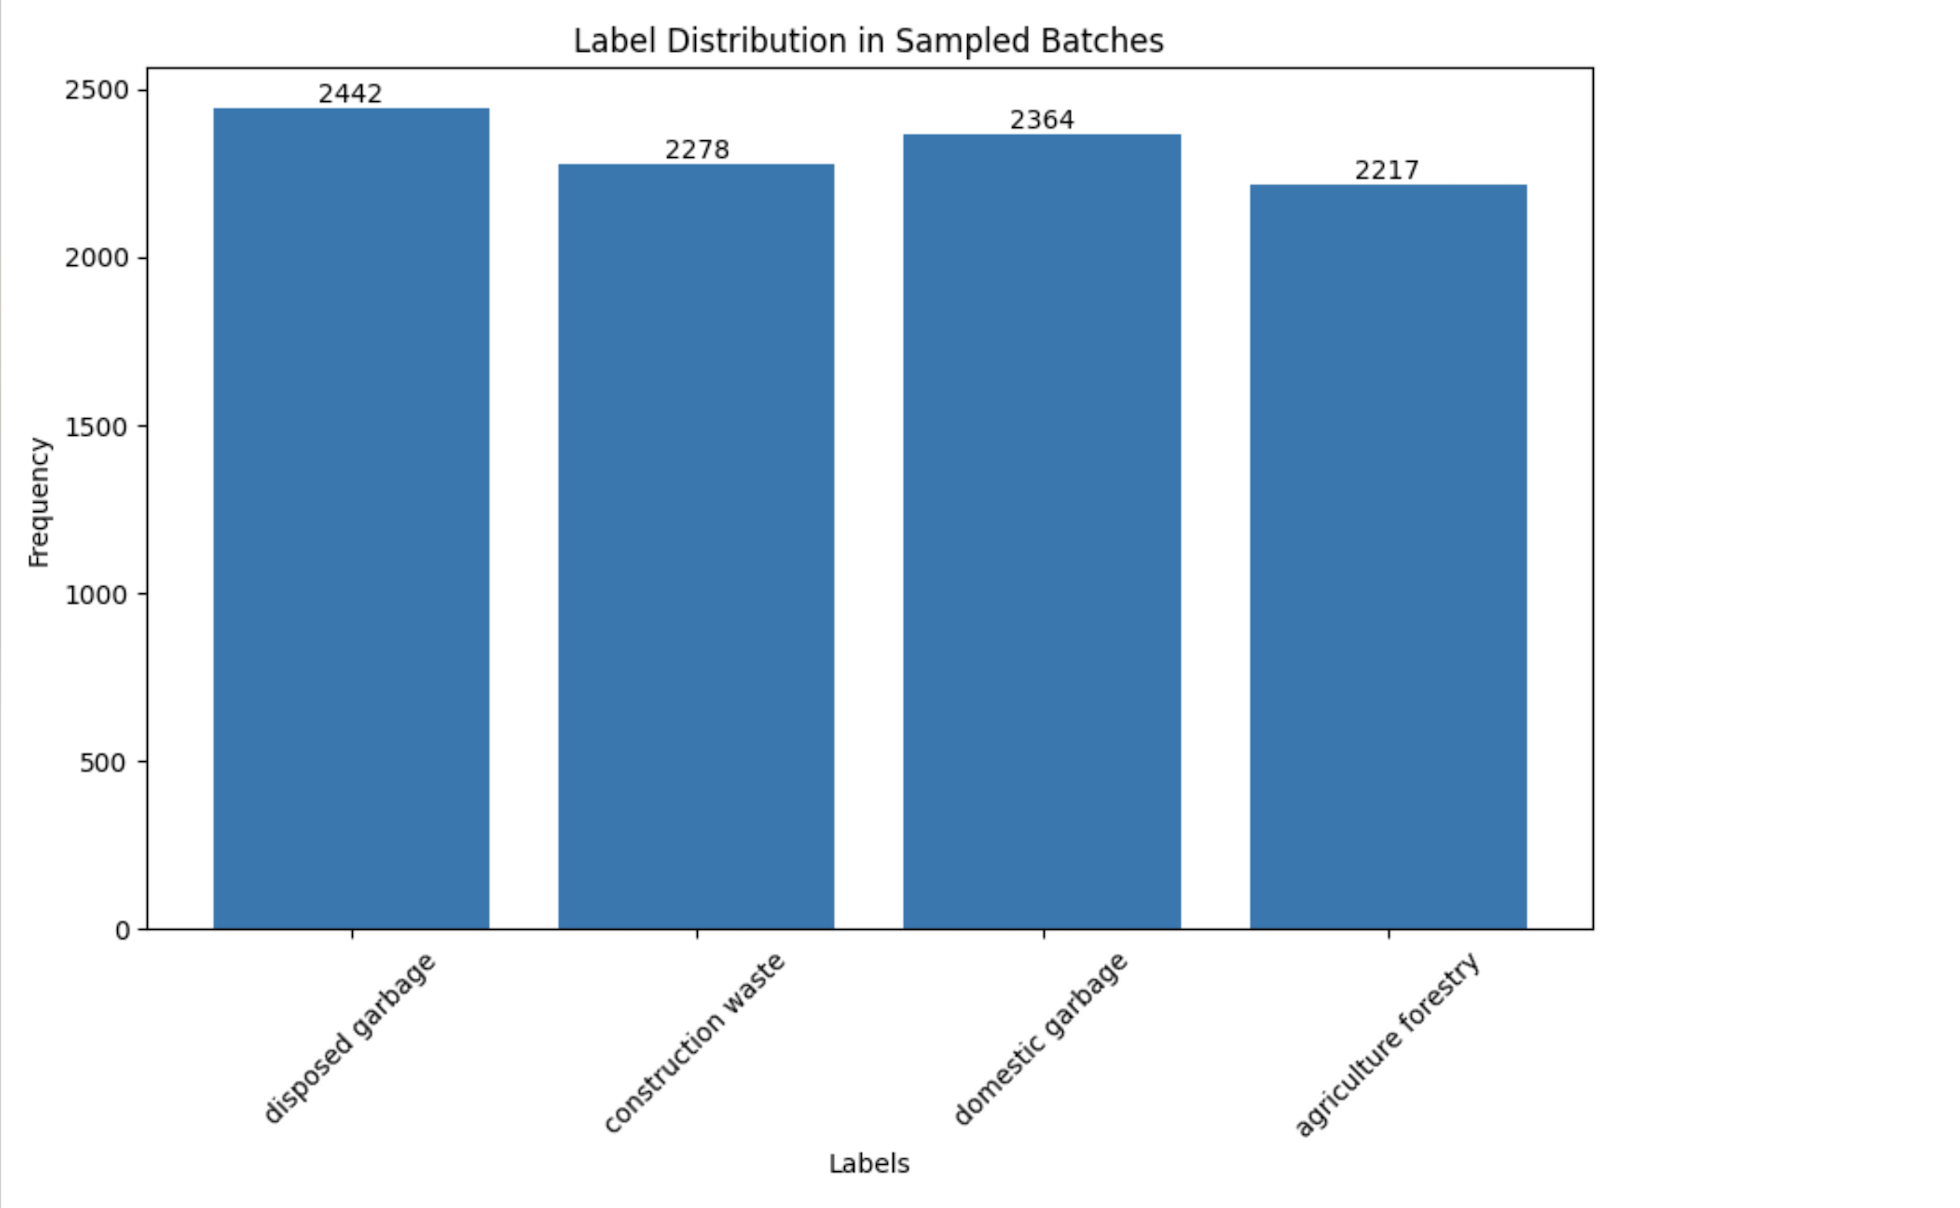

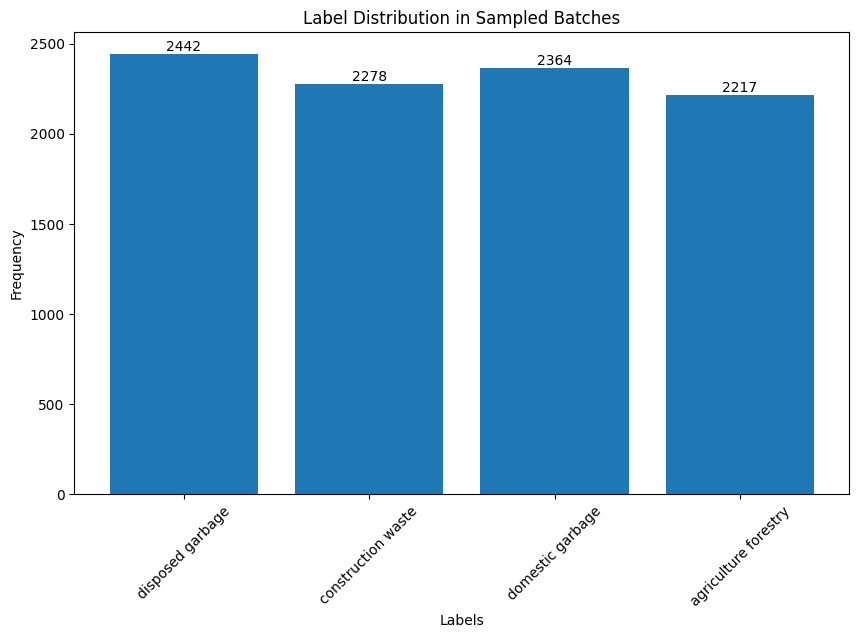

In [11]:
def plot_label_distribution(dataloader, label_map):
    # Distribution of statistical labels
    label_counts = defaultdict(int)

    # Iterate through batches and count labels
    for batch in dataloader:
        for labels in batch[1]: 
            for label in labels['labels']:
                label_counts[label.item()] += 1

    labels, counts = zip(*label_counts.items())
    labels = [list(label_map.keys())[list(label_map.values()).index(lab)] for lab in labels]  

    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, counts)
    plt.xticks(rotation=45)
    plt.xlabel("Labels")
    plt.ylabel("Frequency")
    plt.title("Label Distribution in Sampled Batches")

    # Add counts above each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')  # Display count

    plt.show()

plot_label_distribution(train_dataloader, label_map)

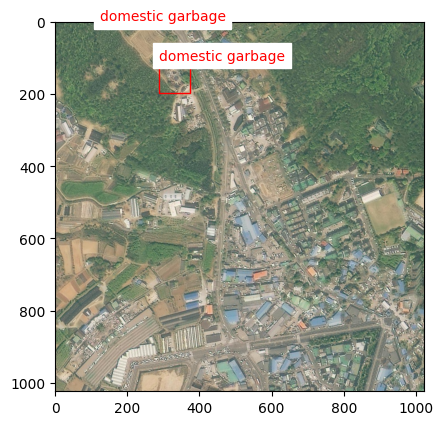

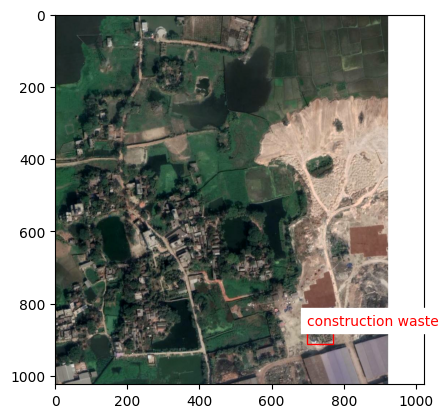

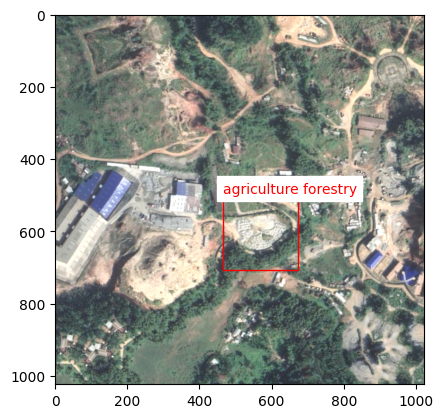

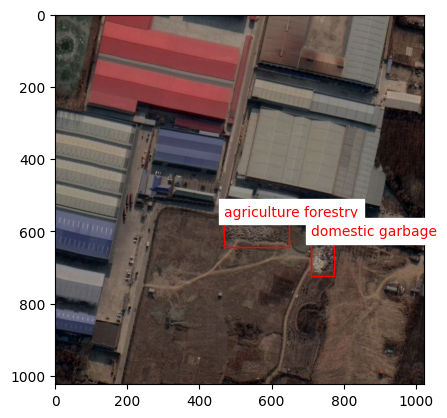

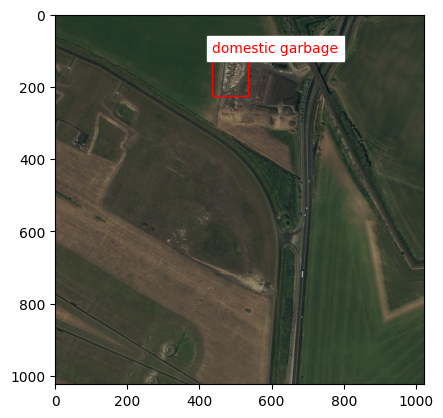

In [15]:
def unnormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
  mean = torch.tensor(mean)[:, None, None]
  std = torch.tensor(std)[:, None, None]
  return image * std + mean

# Functions for visualizing images and their bounding boxes
def visualize_sample(image, boxes, labels, label_map):
  fig, ax = plt.subplots(1)
  # Normalize image to the range [0, 1]
  image = unnormalize(image).permute(1, 2, 0)  # Convert image from (C, H, W) to (H, W, C)
  image = image / 255.0 if image.dtype == torch.uint8 else image.clip(0, 1)

  ax.imshow(image)

  for box, label in zip(boxes, labels):
    xmin, ymin, xmax, ymax = box
    width, height = xmax - xmin, ymax - ymin
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(xmin, ymin - 5, label_map[label.item()], color='red', fontsize=10, backgroundcolor="white")

  plt.show()

batch_size = 1  # Load one image at a time
subset_size = 5  # Take 5 images for testing

# load and test
subset_indices = list(range(subset_size))  # Get indices of the first 5 images
subset = Subset(train_dataset, subset_indices)
dataloader = DataLoader(subset, batch_size=batch_size, shuffle=False)


for batch in dataloader:
  image, boxes, labels = batch['image'][0], batch['boxes'][0], batch['labels'][0]
  visualize_sample(image, boxes, labels, label_name)


## 4. Model Part
## 4.1 Model one: [YOLOv8 + CBAM ](https://github.com/ultralytics/ultralytics)
Based on the YOLOv8 With SGD with Momentum, SGD with Momentum builds upon traditional Stochastic Gradient Descent by introducing a “momentum” component to accelerate convergence and stabilize training. It provides the stability required to capture detailed boundary structures while also allowing the model to generalize effectively across varying environmental conditions in the images.

While the SGD with Momentum optimizer can accelerate training, it mainly focuses on how to effectively update network parameters, CBAM enables the network to extract useful features from data more accurately by introducing an attention mechanism at the feature level, which compensates for the limitation that the optimizer only focuses on gradient updating and ignores feature selection.

After the introduction of CBAM, the training results of this topic show significant improvement in mIoU and mAP:
mIoU enhancement: the overlap between predicted regions and real labels is improved due to the model's ability to focus on critical regions in the image.
mAP Boost: Improved accuracy under different IoU thresholds by increasing the focus on important features and regions, reducing false and missed detections.


In [ ]:
print(torch.cuda.is_available())
device = torch.device("cuda:2")
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
print("Current device:", device)

True
Current device: cuda:2


In [ ]:
def create_yolo_directory_structure(base_dir='yolo_dataset'):
    # Paths for YOLO directory structure
    dirs = {
        'train_images': os.path.join(base_dir, 'images', 'train'),
        'val_images': os.path.join(base_dir, 'images', 'val'),
        'test_images': os.path.join(base_dir, 'images', 'test'),
        'train_labels': os.path.join(base_dir, 'labels', 'train'),
        'val_labels': os.path.join(base_dir, 'labels', 'val'),
        'test_labels': os.path.join(base_dir, 'labels', 'test')
    }
    for dir_path in dirs.values():
        os.makedirs(dir_path, exist_ok=True)
    return dirs

def save_yolo_labels(dataloader, output_image_dir, output_label_dir):
    transform = transforms.ToPILImage()  # Create a transform to convert tensors to PIL images
    for batch_idx, (images, targets) in enumerate(dataloader):
        for i, (image, target) in enumerate(zip(images, targets)):
            img_id = f"{target['img_id']}"
            # Convert tensor to PIL Image
            pil_image = transform(image)

            # Save image
            img_save_path = os.path.join(output_image_dir, f"{img_id}.jpg")
            pil_image.save(img_save_path)

            # Convert bounding boxes to YOLO format and save to label file
            label_save_path = os.path.join(output_label_dir, f"{img_id}.txt")
            with open(label_save_path, 'w') as f:
                for bbox, class_id in zip(target['boxes'], target['labels']):
                    # YOLO format: class_id, x_center, y_center, width, height
                    x_min, y_min, x_max, y_max = bbox.tolist()
                    img_width, img_height = image.shape[2], image.shape[1]

                    # Normalize bounding box coordinates
                    x_center = (x_min + x_max) / 2 / img_width
                    y_center = (y_min + y_max) / 2 / img_height
                    width = (x_max - x_min) / img_width
                    height = (y_max - y_min) / img_height

                    # Write each annotation to file
                    f.write(f"{int(class_id)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

# Directory paths for YOLO dataset
dirs = create_yolo_directory_structure()

# Save labels and images for train, validation, and test dataloaders
save_yolo_labels(train_dataloader, dirs['train_images'], dirs['train_labels'])
save_yolo_labels(val_dataloader, dirs['val_images'], dirs['val_labels'])
save_yolo_labels(test_dataloader, dirs['test_images'], dirs['test_labels'])

# Create the dataset.yaml file
dataset_yaml = {
    'train': os.path.abspath(dirs['train_images']),
    'val': os.path.abspath(dirs['val_images']),
    'test': os.path.abspath(dirs['test_images']),
    'nc': len(label_name),
    'names': list(label_name.values())
}

# Save dataset.yaml
with open(os.path.join('yolo_dataset', 'dataset.yaml'), 'w') as f:
    yaml.dump(dataset_yaml, f)

print("YOLO dataset structure created successfully.")

YOLO dataset structure created successfully.


In [ ]:
# Check the labels distribution in yolo
def check_yolo_label(labels_dir, mode):
    label_counter = Counter()
    
    for filename in os.listdir(labels_dir):
        if filename.endswith('.txt'):
            with open(os.path.join(labels_dir, filename), 'r') as f:
                for line in f:
                    # Each line in the YOLO format starts with a category number
                    class_id = line.split()[0]  
                    label_counter[class_id] += 1
    
    for class_id, count in label_counter.items():
        print(f'{mode}: Class ID: {class_id}, Count: {count}')

train_label = check_yolo_label('yolo_dataset/labels/train', 'train')
val_label = check_yolo_label('yolo_dataset/labels/val', 'val')
test_label = check_yolo_label('yolo_dataset/labels/test', 'test')


train: Class ID: 0, Count: 2250
train: Class ID: 3, Count: 891
train: Class ID: 1, Count: 347
train: Class ID: 2, Count: 21
val: Class ID: 0, Count: 1525
val: Class ID: 1, Count: 174
val: Class ID: 3, Count: 476
val: Class ID: 2, Count: 9
test: Class ID: 3, Count: 126
test: Class ID: 1, Count: 142
test: Class ID: 0, Count: 635
test: Class ID: 2, Count: 3


In [ ]:
from ultralytics import YOLO      

if __name__ == '__main__':
    model = YOLO('yolov8l.pt')
    model.train(
        data="yolo_dataset/dataset.yaml", 
        epochs=10, 
        imgsz=640,
        optimizer='SGD'
    )


WARNING ⚠️ Python>=3.10 is required, but Python==3.8.15 is currently installed 
New https://pypi.org/project/ultralytics/8.3.31 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.18 🚀 Python-3.8.15 torch-2.4.1+cu121 CUDA:0 (NVIDIA RTX A4500, 20171MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=yolo_dataset/dataset.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train14, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.5, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agn

train: Scanning /home/sqs/dolores/yolo_dataset/labels/train.cache... 2043 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2043/2043 [00:00<?, ?it/s]
val: Scanning /home/sqs/dolores/yolo_dataset/labels/val.cache... 1264 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1264/1264 [00:00<?, ?it/s]


Plotting labels to runs/detect/train14/labels.jpg... 
121212122121212121212
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train14
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      9.85G      2.304       4.63      2.126         22        640: 100%|██████████| 128/128 [00:58<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:13<00:00,  3.07it/s]


                   all       1264       2184      0.335     0.0877     0.0359     0.0119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      9.72G      2.052      3.165      1.803         14        640: 100%|██████████| 128/128 [00:41<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:10<00:00,  3.80it/s]


                   all       1264       2184      0.354     0.0881     0.0365      0.013

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      9.85G      2.115      3.115      1.852         13        640: 100%|██████████| 128/128 [00:41<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:11<00:00,  3.64it/s]


                   all       1264       2184      0.291     0.0573     0.0203    0.00705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      9.84G      2.159       3.24       1.95         11        640: 100%|██████████| 128/128 [00:40<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:11<00:00,  3.60it/s]


                   all       1264       2184      0.287     0.0766     0.0142    0.00423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      9.84G      2.202      3.119      1.925         14        640: 100%|██████████| 128/128 [00:41<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:10<00:00,  3.72it/s]


                   all       1264       2184      0.338     0.0616      0.041     0.0134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      9.86G      2.151      2.981      1.901         17        640: 100%|██████████| 128/128 [00:41<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:10<00:00,  3.78it/s]


                   all       1264       2184     0.0816      0.123     0.0436     0.0144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      9.81G      2.068      2.811      1.872         20        640: 100%|██████████| 128/128 [00:40<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:10<00:00,  3.77it/s]


                   all       1264       2184       0.46      0.144     0.0945     0.0341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      9.81G      1.994      2.648      1.799         17        640: 100%|██████████| 128/128 [00:40<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:10<00:00,  3.79it/s]


                   all       1264       2184      0.215       0.15      0.097     0.0355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10       9.8G      1.937      2.522      1.756         17        640: 100%|██████████| 128/128 [00:40<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:10<00:00,  3.81it/s]


                   all       1264       2184      0.412      0.191      0.168     0.0711

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10       9.8G      1.879      2.372      1.716         15        640: 100%|██████████| 128/128 [00:40<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:10<00:00,  3.83it/s]


                   all       1264       2184      0.445      0.213      0.187     0.0763

10 epochs completed in 0.157 hours.
Optimizer stripped from runs/detect/train14/weights/last.pt, 87.6MB
Optimizer stripped from runs/detect/train14/weights/best.pt, 87.6MB

Validating runs/detect/train14/weights/best.pt...
Ultralytics 8.3.18 🚀 Python-3.8.15 torch-2.4.1+cu121 CUDA:0 (NVIDIA RTX A4500, 20171MiB)
Model summary (fused): 268 layers, 43,609,692 parameters, 0 gradients, 164.8 GFLOPs


In [ ]:
# verification model
metrics = model.val(data='yolo_dataset/dataset.yaml')  # Validation set metrics
results = model.predict(source='yolo_dataset/images/test', save=True)


NameError: name 'model' is not defined

## 4.2 Model two: ResNet50-Faster-RCNN & ResNet101-Faster-RCNN 
This dataset have high resolution (1024 x 1024) and contain multiple small bounding boxes, making it challenging to accurately detect the targets. We use ResNet50-Faster-RCNN as the baseline model. As a benchmark model, it combines powerful feature extraction capabilities and efficient object detection techniques, providing a stable reference point for comparing and evaluating new models or methods. Subsequently, we adjusted the backbone network to ResNet101 and hoped of achieving better results.

ResNet50-Faster-RCNN is a target detection model that combines ResNet50 and Faster-RCNN. ResNet50 is a 50-layer deep convolutional neural network that stabilizes training and improves efficiency through residual connections. Faster-RCNN consists of a Region Proposal Network (RPN) for generating candidate regions and a Fast-RCNN for classifying these regions and refining their bounding boxes. In this combined model, ResNet50 serves as the backbone network for feature extraction, RPN generates candidate regions from the feature maps, and Fast-RCNN classifies these regions and adjusts their bounding boxes.

Additionally, we tried to replace the backbone network with ResNet101. Compared to ResNet50, the basic unit of each module in ResNet101 remains the bottleneck block, but the depth of the third module is significantly increased.




## We trained these models on the rented graphics card
## 4.2.1 ResNet50-Faster-R-CNN training and validation

In [7]:
import torchvision

# from backbone import resnet50_fpn_backbone
import rcnn.transforms
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights, FasterRCNN_ResNet50_FPN_V2_Weights



def create_resnet50_model(num_classes):

    # get number of input features for the classifier
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


## 4.2.2 ResNet101-Faster-R-CNN

In [ ]:

from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.rpn import AnchorGenerator



def create_res101_model(num_classes, load_pretrain_weights=True):
    backbone = resnet_fpn_backbone('resnet101', pretrained=load_pretrain_weights)

    anchor_generator = AnchorGenerator(
        sizes=((16,), (32,), (64,), (128,), (256,)),  
        aspect_ratios=((0.5, 1.0, 2.0),) * 5        
    )


    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0', '1', '2', '3'],
        output_size=7,  
        sampling_ratio=2   
    )


    model_resnet101_fpn = torchvision.models.detection.FasterRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )


    return model_resnet101_fpn



## 4.2.3 Model training

In [15]:
from train_utils import train_eval_utils as utils
import rcnn.transforms as transforms
import os
import torch
import datetime
from rcnn.dataset import VOCDataset
def train_model(model, name):

  voc_root = 'VOC2012'
  transform = {
    "train": transforms.Compose([transforms.ToTensor(),
                                  transforms.RandomHorizontalFlip(0.5),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    "val": transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
  }
  train_data_set = VOCDataset(os.path.join(voc_root, 'train'), 'train.txt', transforms=transform['train'])
  train_data_loader = torch.utils.data.DataLoader(train_data_set, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
  val_dataset = VOCDataset(os.path.join(voc_root, 'test'), "test.txt", transforms=transform["val"])
  val_data_set_loader = torch.utils.data.DataLoader(val_dataset,
                                                      batch_size=8,
                                                      shuffle=False,
                                                      pin_memory=True,
                                                      collate_fn=lambda x: tuple(zip(*x)))
  params = [p for p in model.parameters() if p.requires_grad]
  optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
  results_file = "rcnn/coco_info/results_{}_{}.txt".format(name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  metric_file = "rcnn/coco_info/metric_{}_{}.txt".format(name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


  # 训练模型
  num_epochs = 2
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
  model.to(device)
  lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


  train_loss = []
  learning_rate = []
  val_map = []
  accs = []
  recalls = []
 
  for epoch in range(0, num_epochs):
    # train for one epoch, printing every 10 iterations
    mean_loss, lr = utils.train_one_epoch(model, optimizer, train_data_loader,
                                          device=device, epoch=epoch,
                                          print_freq=50, warmup=True,
                                          scaler=None)
    train_loss.append(mean_loss.item())
    learning_rate.append(lr)

    # update the learning rate
    lr_scheduler.step()

    # evaluate on the test dataset
    coco_info, mean_acc, mean_recall = utils.evaluate(model, val_data_set_loader, device=device)
    accs.append(mean_acc)
    accs.append(mean_recall)
    # write into txt
    with open(metric_file, "a") as f:
        metirc_info = f"{mean_acc} {mean_recall} {mean_loss}"
        f.write(metirc_info + "\n")

    with open(results_file, "a") as f:
        result_info = [f"{i:.4f}" for i in coco_info + [mean_loss.item()]] + [f"{lr:.6f}"]
        txt = "epoch:{} {}".format(epoch, '  '.join(result_info))
        f.write(txt + "\n")

    val_map.append(coco_info[1])  # pascal mAP

    # save weights
    if epoch in (1, 4, 5, 9, 10, 14):
        save_files = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'epoch': epoch}
        torch.save(save_files, "rcnn/save_weights/{}Fpn-model-{}.pth".format(name, epoch))

# Model training
model_resnet50 = create_resnet50_model(5)
train_model(model_resnet50, "res50")
model_resnet101 = create_res101_model(5)
train_model(model_resnet101, "res101")

Epoch: [0]  [  0/334]  eta: 0:03:23.224349  lr: 0.000020  loss: 1.6929 (1.6929)  loss_classifier: 1.2569 (1.2569)  loss_box_reg: 0.0150 (0.0150)  loss_objectness: 0.4158 (0.4158)  loss_rpn_box_reg: 0.0053 (0.0053)  time: 0.6085  data: 0.0618  max mem: 5726
Epoch: [0]  [ 50/334]  eta: 0:02:12.740409  lr: 0.000770  loss: 0.2612 (0.4839)  loss_classifier: 0.1234 (0.2959)  loss_box_reg: 0.0651 (0.0505)  loss_objectness: 0.0655 (0.1308)  loss_rpn_box_reg: 0.0071 (0.0067)  time: 0.4187  data: 0.0561  max mem: 5883
Epoch: [0]  [100/334]  eta: 0:01:42.750382  lr: 0.001520  loss: 0.3133 (0.3627)  loss_classifier: 0.1617 (0.2062)  loss_box_reg: 0.1186 (0.0654)  loss_objectness: 0.0290 (0.0855)  loss_rpn_box_reg: 0.0040 (0.0056)  time: 0.4110  data: 0.0563  max mem: 5883
Epoch: [0]  [150/334]  eta: 0:01:22.919122  lr: 0.002270  loss: 0.2585 (0.3279)  loss_classifier: 0.1122 (0.1775)  loss_box_reg: 0.1191 (0.0784)  loss_objectness: 0.0237 (0.0666)  loss_rpn_box_reg: 0.0036 (0.0054)  time: 0.4129  

/home/xk/anaconda3/envs/nn/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: [0]  [  0/334]  eta: 0:03:18.768472  lr: 0.000020  loss: 1.9981 (1.9981)  loss_classifier: 1.3127 (1.3127)  loss_box_reg: 0.0008 (0.0008)  loss_objectness: 0.6825 (0.6825)  loss_rpn_box_reg: 0.0021 (0.0021)  time: 0.5951  data: 0.0617  max mem: 7942
Epoch: [0]  [ 50/334]  eta: 0:02:31.460331  lr: 0.000770  loss: 0.0879 (0.4222)  loss_classifier: 0.0357 (0.2026)  loss_box_reg: 0.0077 (0.0132)  loss_objectness: 0.0410 (0.1994)  loss_rpn_box_reg: 0.0034 (0.0070)  time: 0.5230  data: 0.0523  max mem: 8174
Epoch: [0]  [100/334]  eta: 0:02:11.265048  lr: 0.001520  loss: 0.0847 (0.2585)  loss_classifier: 0.0399 (0.1236)  loss_box_reg: 0.0203 (0.0151)  loss_objectness: 0.0221 (0.1146)  loss_rpn_box_reg: 0.0023 (0.0052)  time: 0.5310  data: 0.0539  max mem: 8174
Epoch: [0]  [150/334]  eta: 0:01:44.691850  lr: 0.002270  loss: 0.1675 (0.2049)  loss_classifier: 0.0517 (0.0978)  loss_box_reg: 0.0284 (0.0170)  loss_objectness: 0.0584 (0.0854)  loss_rpn_box_reg: 0.0290 (0.0047)  time: 0.5370  

## 4.2.4 Model Validation

In [ ]:

import rcnn.transforms
from tqdm import tqdm
from rcnn.vali_dataset import vali_dataset
from torchvision.ops import box_iou
from rcnn.train_utils import get_coco_api_from_dataset, CocoEvaluator
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import torchvision
import json
import numpy as np


def summarize(self, catId=None):
    """
    Compute and display summary metrics for evaluation results.
    Note this functin can *only* be applied on the default parameter setting
    """

    def _summarize(ap=1, iouThr=None, areaRng='all', maxDets=100):
        p = self.params
        iStr = ' {:<18} {} @[ IoU={:<9} | area={:>6s} | maxDets={:>3d} ] = {:0.3f}'
        titleStr = 'Average Precision' if ap == 1 else 'Average Recall'
        typeStr = '(AP)' if ap == 1 else '(AR)'
        iouStr = '{:0.2f}:{:0.2f}'.format(p.iouThrs[0], p.iouThrs[-1]) \
            if iouThr is None else '{:0.2f}'.format(iouThr)

        aind = [i for i, aRng in enumerate(p.areaRngLbl) if aRng == areaRng]
        mind = [i for i, mDet in enumerate(p.maxDets) if mDet == maxDets]

        if ap == 1:
            # dimension of precision: [TxRxKxAxM]
            s = self.eval['precision']
            # IoU
            if iouThr is not None:
                t = np.where(iouThr == p.iouThrs)[0]
                s = s[t]

            if isinstance(catId, int):
                s = s[:, :, catId, aind, mind]
            else:
                s = s[:, :, :, aind, mind]

        else:
            # dimension of recall: [TxKxAxM]
            s = self.eval['recall']
            if iouThr is not None:
                t = np.where(iouThr == p.iouThrs)[0]
                s = s[t]

            if isinstance(catId, int):
                s = s[:, catId, aind, mind]
            else:
                s = s[:, :, aind, mind]

        if len(s[s > -1]) == 0:
            mean_s = -1
        else:
            mean_s = np.mean(s[s > -1])

        print_string = iStr.format(titleStr, typeStr, iouStr, areaRng, maxDets, mean_s)
        return mean_s, print_string

    stats, print_list = [0] * 12, [""] * 12
    stats[0], print_list[0] = _summarize(1)
    stats[1], print_list[1] = _summarize(1, iouThr=.5, maxDets=self.params.maxDets[2])
    stats[2], print_list[2] = _summarize(1, iouThr=.75, maxDets=self.params.maxDets[2])
    stats[3], print_list[3] = _summarize(1, areaRng='small', maxDets=self.params.maxDets[2])
    stats[4], print_list[4] = _summarize(1, areaRng='medium', maxDets=self.params.maxDets[2])
    stats[5], print_list[5] = _summarize(1, areaRng='large', maxDets=self.params.maxDets[2])
    stats[6], print_list[6] = _summarize(0, maxDets=self.params.maxDets[0])
    stats[7], print_list[7] = _summarize(0, maxDets=self.params.maxDets[1])
    stats[8], print_list[8] = _summarize(0, maxDets=self.params.maxDets[2])
    stats[9], print_list[9] = _summarize(0, areaRng='small', maxDets=self.params.maxDets[2])
    stats[10], print_list[10] = _summarize(0, areaRng='medium', maxDets=self.params.maxDets[2])
    stats[11], print_list[11] = _summarize(0, areaRng='large', maxDets=self.params.maxDets[2])

    print_info = "\n".join(print_list)

    if not self.eval:
        raise Exception('Please run accumulate() first')

    return stats, print_info


# calculte IoU and F1 Score 
def calculate_metrics_for_boxes(pred_boxes, pred_labels, gt_boxes, gt_labels, num_classes, iou_threshold=0.5):
    ious = np.zeros(num_classes)
    tp = np.zeros(num_classes)
    fp = np.zeros(num_classes)
    fn = np.zeros(num_classes)
    iou_counts = np.zeros(num_classes)

    for cls in range(num_classes):
        pred_cls_boxes = pred_boxes[pred_labels == cls]
        gt_cls_boxes = gt_boxes[gt_labels == cls]

        if len(pred_cls_boxes) > 0 and len(gt_cls_boxes) > 0:
            iou_matrix = box_iou(torch.tensor(pred_cls_boxes), torch.tensor(gt_cls_boxes))
            max_iou_per_pred, _ = iou_matrix.max(dim=1)  

            # TP, FP, FN
            tp[cls] = (max_iou_per_pred >= iou_threshold).sum().item()  
            fp[cls] = len(pred_cls_boxes) - tp[cls]  
            fn[cls] = len(gt_cls_boxes) - tp[cls]    


            ious[cls] = max_iou_per_pred.mean().item() if tp[cls] > 0 else 0
            iou_counts[cls] = 1 if tp[cls] > 0 else 0
        elif len(pred_cls_boxes) > 0: 
            fp[cls] = len(pred_cls_boxes)
        elif len(gt_cls_boxes) > 0: 
            fn[cls] = len(gt_cls_boxes)

    return ious, iou_counts, tp, fp, fn

def unnormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
  mean = torch.tensor(mean)[:, None, None]
  std = torch.tensor(std)[:, None, None]
  return image * std + mean

# Functions for visualizing images and their bounding boxes
def visualize_sample(image, boxes, labels, label_map, file_name, name=''):
  fig, ax = plt.subplots(1)
  # Normalize image to the range [0, 1]
  image = unnormalize(image).permute(1, 2, 0)  # Convert image from (C, H, W) to (H, W, C)
  image = image / 255.0 if image.dtype == torch.uint8 else image.clip(0, 1)

  ax.imshow(image)

  for box, label in zip(boxes, labels):
    xmin, ymin, xmax, ymax = box
    width, height = xmax - xmin, ymax - ymin
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(xmin, ymin - 5, label_map[label.item()], color='red', fontsize=10, backgroundcolor="white")

  plt.savefig(f'output_{name}/' + file_name + '.png')
  plt.close()



def validate(model, weights_path, name=''):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
    print("Using {} device training.".format(device.type))

    data_transform = {
        "val": transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    }

    # read class_indict
    label_json_path = 'rcnn/classes.json'
    assert os.path.exists(label_json_path), "json file {} dose not exist.".format(label_json_path)
    with open(label_json_path, 'r') as f:
        class_dict = json.load(f)

    category_index = {v: k for k, v in class_dict.items()}

    VOC_root = 'VOC2012/test'

    batch_size = 8
    with open('rcnn/classes.json', 'r') as json_file:
        label_map = json.load(json_file)
    label_name = {v : k for k, v in label_map.items()}

    # load validation data set
    val_dataset = vali_dataset(VOC_root, 'test.txt', data_transform["val"])
    val_dataset_loader = torch.utils.data.DataLoader(val_dataset,
                                                     batch_size=8,
                                                     shuffle=False,
                                                     pin_memory=True,
                                                     collate_fn=val_dataset.collate_fn)

    num_classes = 4
    iou_sum = np.zeros(num_classes)
    iou_count = np.zeros(num_classes)
    tp_sum = np.zeros(num_classes)
    fp_sum = np.zeros(num_classes)
    fn_sum = np.zeros(num_classes)

    assert os.path.exists(weights_path), "not found {} file.".format(weights_path)
    weights_dict = torch.load(weights_path)
    weights_dict = weights_dict["model"] if "model" in weights_dict else weights_dict
    model.load_state_dict(weights_dict)


    model.to(device)

    # evaluate on the test dataset
    coco = get_coco_api_from_dataset(val_dataset)
    iou_types = ["bbox"]
    coco_evaluator = CocoEvaluator(coco, iou_types)
    cpu_device = torch.device("cpu")

    model.eval()
    with torch.no_grad():
        for image, targets in tqdm(val_dataset_loader, desc="validation..."):

            image = list(img.to(device) for img in image)

            # inference
            outputs = model(image)      
            

            outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

            for img, output, target in zip(image, outputs, targets):
                pred_boxes = output["boxes"].cpu().numpy()
                pred_labels = output["labels"].cpu().numpy()
                pred_scores = output["scores"].cpu().numpy()
                
                gt_boxes = target["boxes"].cpu().numpy()
                gt_labels = target["labels"].cpu().numpy()
                
                # 计算该批次的 IoU 和 F1 相关计数并累计
                batch_ious, batch_iou_counts, batch_tp, batch_fp, batch_fn = calculate_metrics_for_boxes(pred_boxes, pred_labels, gt_boxes, gt_labels, num_classes)
                iou_sum += batch_ious
                iou_count += batch_iou_counts
                tp_sum += batch_tp
                fp_sum += batch_fp
                fn_sum += batch_fn
                
                # visualize_sample(img.to(cpu_device), pred_boxes, pred_labels, label_name, target['name'], name)

            res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
            coco_evaluator.update(res)
            

    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()

    coco_eval = coco_evaluator.coco_eval["bbox"]

    # 计算所有类别的 mIoU
    miou = np.sum(iou_sum) / np.sum(iou_count)
    print(f"Mean IoU (mIoU): {miou}")

    # calculate Precision, Recall, F1 Score
    precision = tp_sum / (tp_sum + fp_sum + 1e-6)  
    recall = tp_sum / (tp_sum + fn_sum + 1e-6)   
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)  
    mean_f1_score = np.nanmean(f1_score)  
    print(f'recall: {recall}')
    print(f"F1 Score per class: {f1_score}")
    print(f"Mean F1 Score: {mean_f1_score}")




weights_path_res50 = "rcnn/save_weights/res50Fpn-model.pth"
weights_path_res101 = "rcnn/save_weights/res101Fpn-model.pth"
model_res50 = create_resnet50_model(5)
model_res101 = create_res101_model(5, False)
validate(model_res50, weights_path_res50, 'res50')
validate(model_res101, weights_path_res101, 'res101')


Using cuda device training.


/tmp/ipykernel_56295/1769354100.py:185: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_dict = torch.load(weights_path)


creating index...
index created!


validation...: 100%|██████████| 90/90 [00:20<00:00,  4.31it/s]


Accumulating evaluation results...
DONE (t=0.12s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.095
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.214
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.063
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.126
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.087
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.216
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.363
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.370
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.413
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= 

validation...: 100%|██████████| 90/90 [00:26<00:00,  3.37it/s]

Accumulating evaluation results...
DONE (t=0.08s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.089
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.250
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.118
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.071
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.172
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.270
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.273
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.280
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= 

## 5. Result
All models are trained by RTX3080 and  are designed the model is trained effectively with balanced class distribution, efficient sampling, and appropriate initialization strategies, leading to improved performance across different classes. As for the additional module in the models, we set different initialization methods, and follow Xavier distribution.
### 5.1 YOLOv8 compare to YOLOv8 + CBAM
Figure1 reults in YOLOv8:
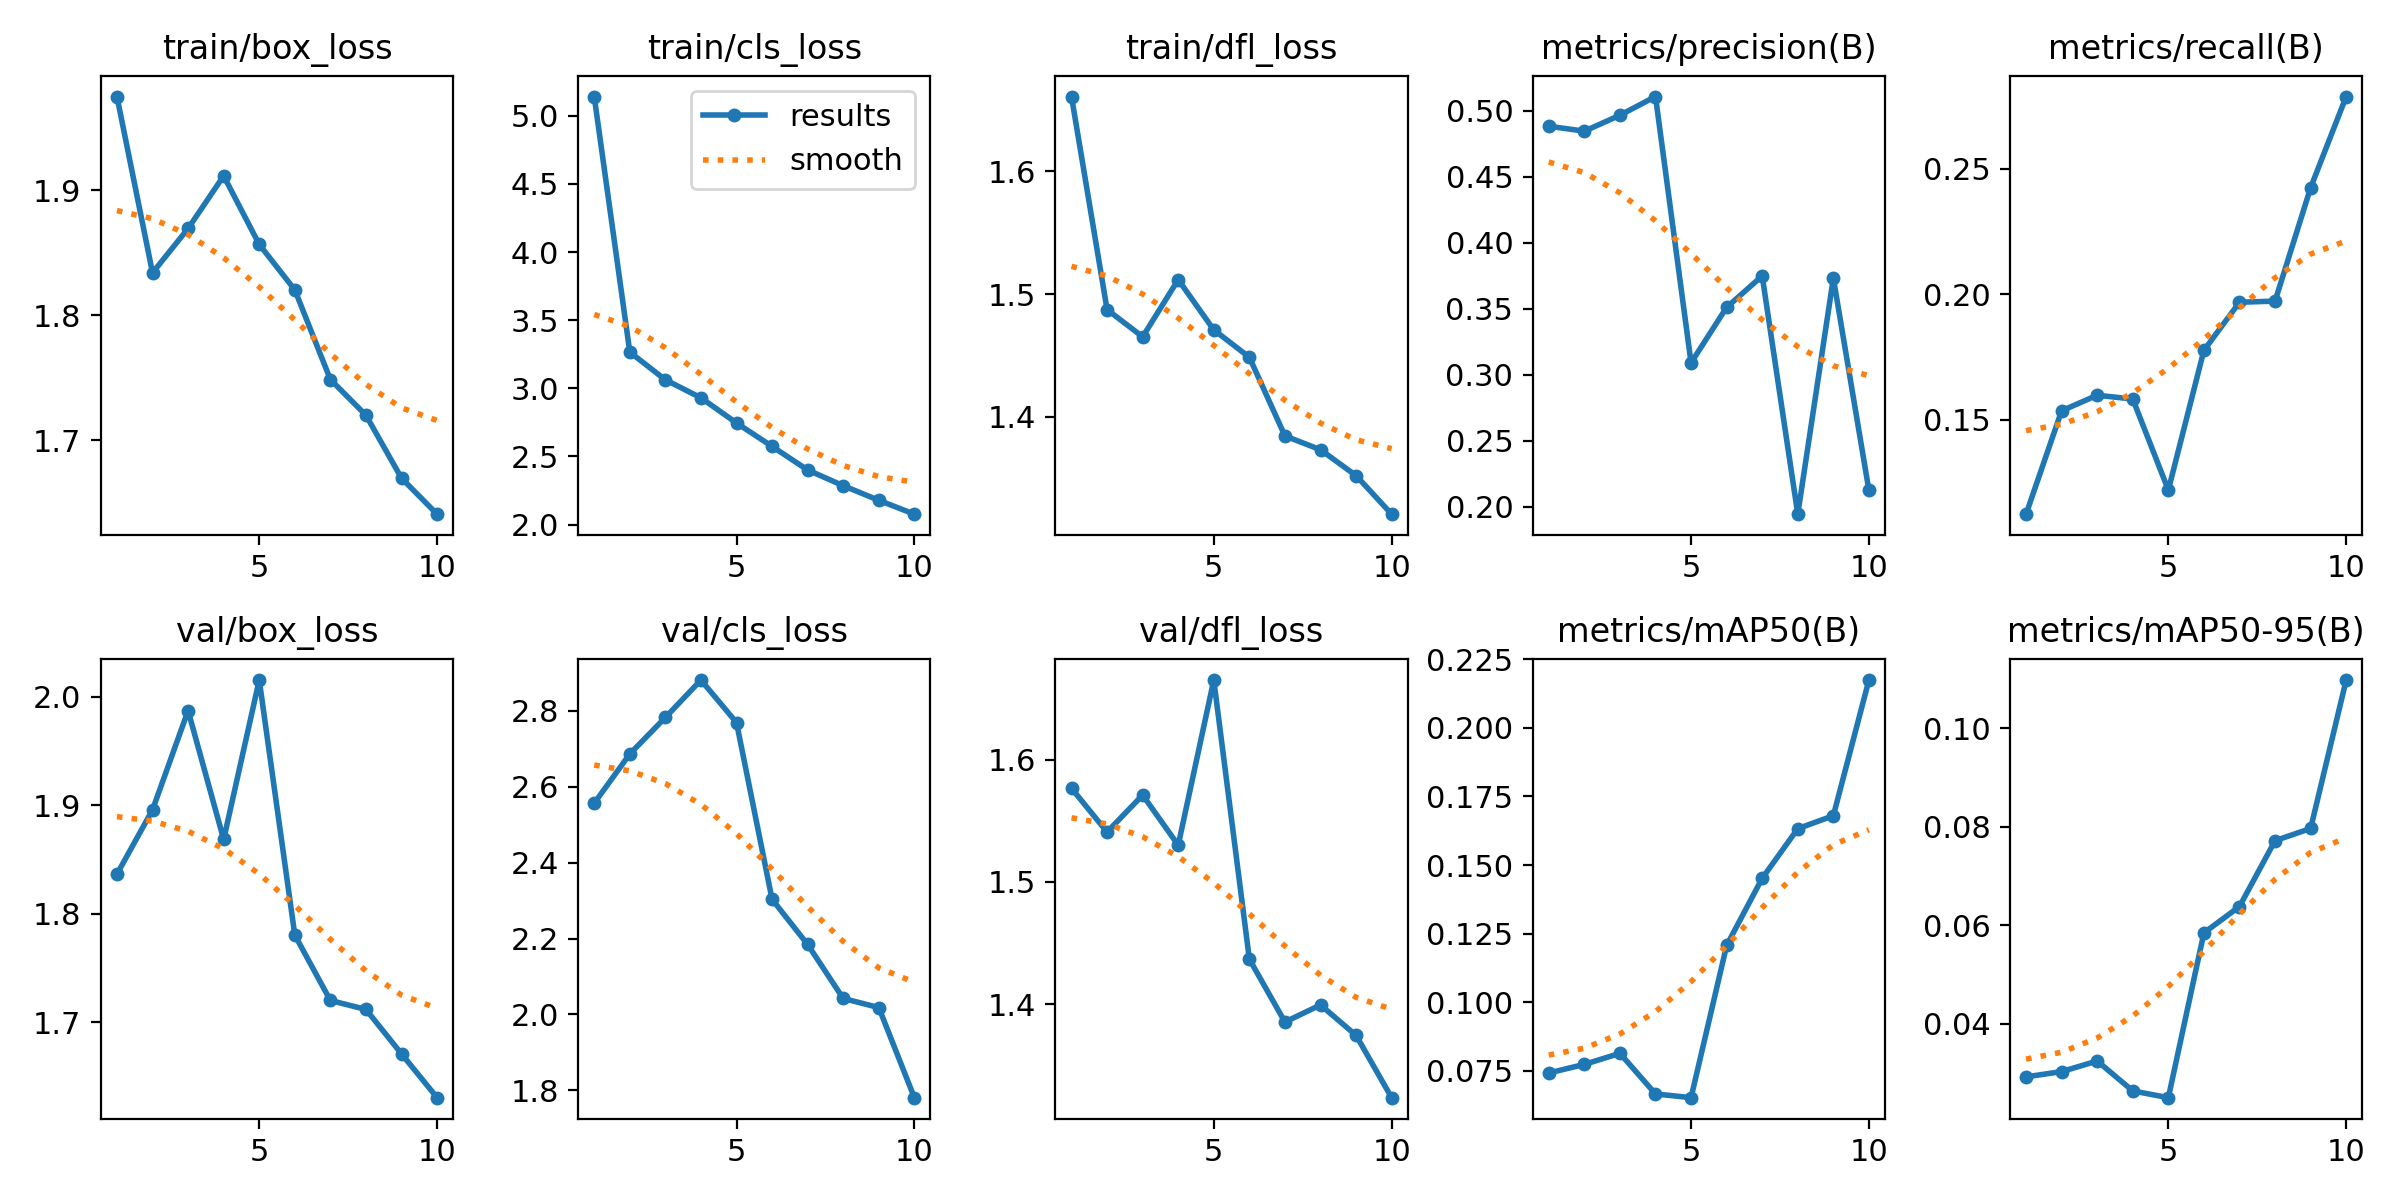
Figure2 reults in YOLOv8+CBAM:
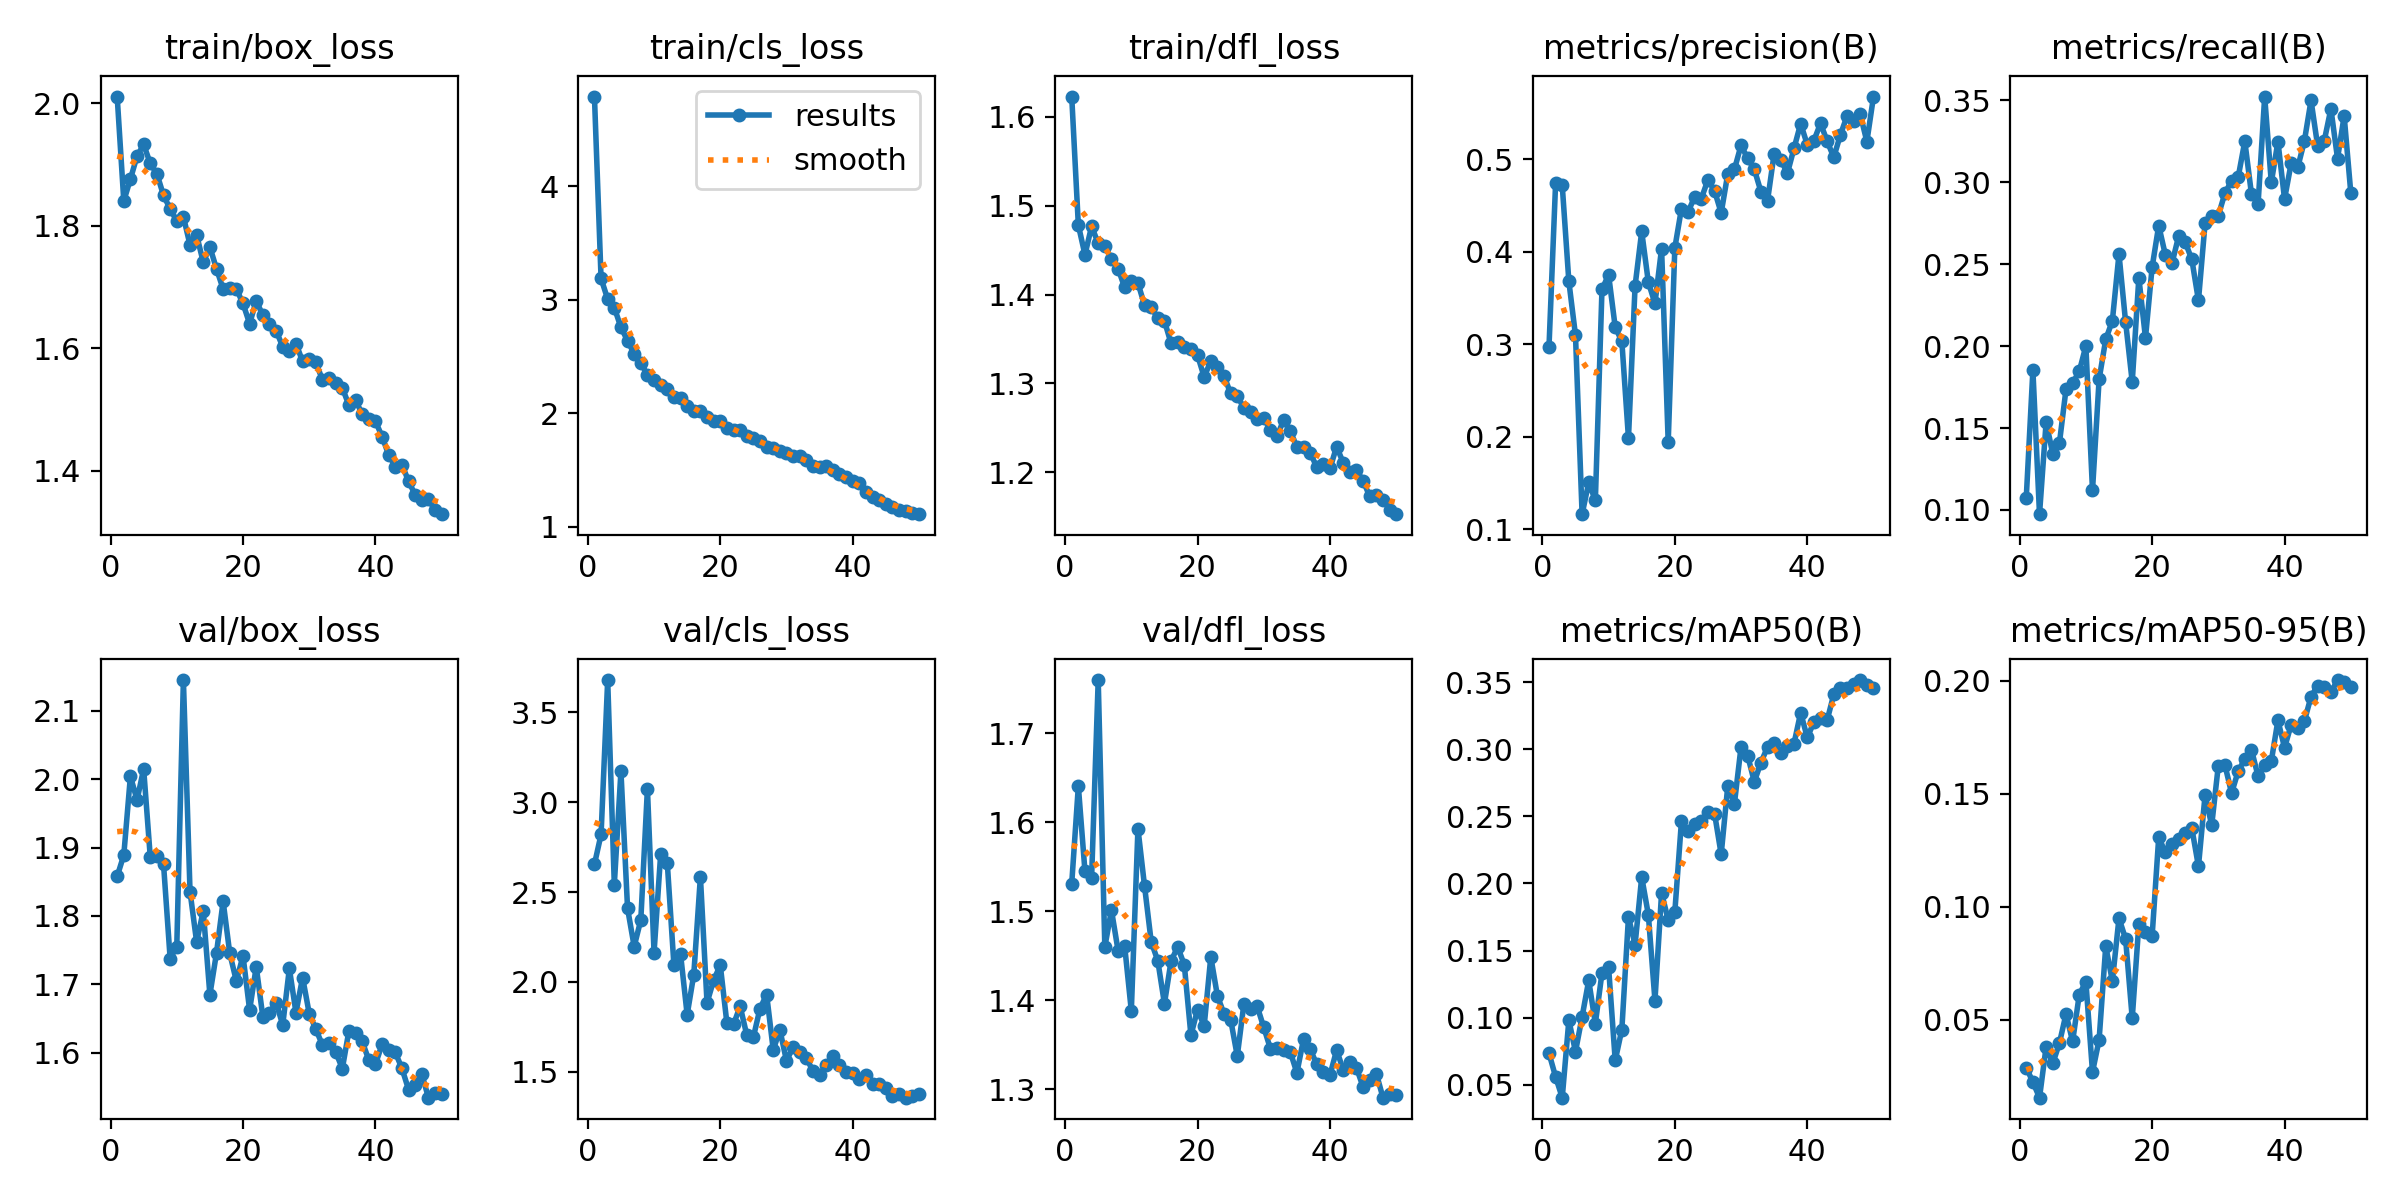
Figure3 validation batch2 prediction YOLOv8:
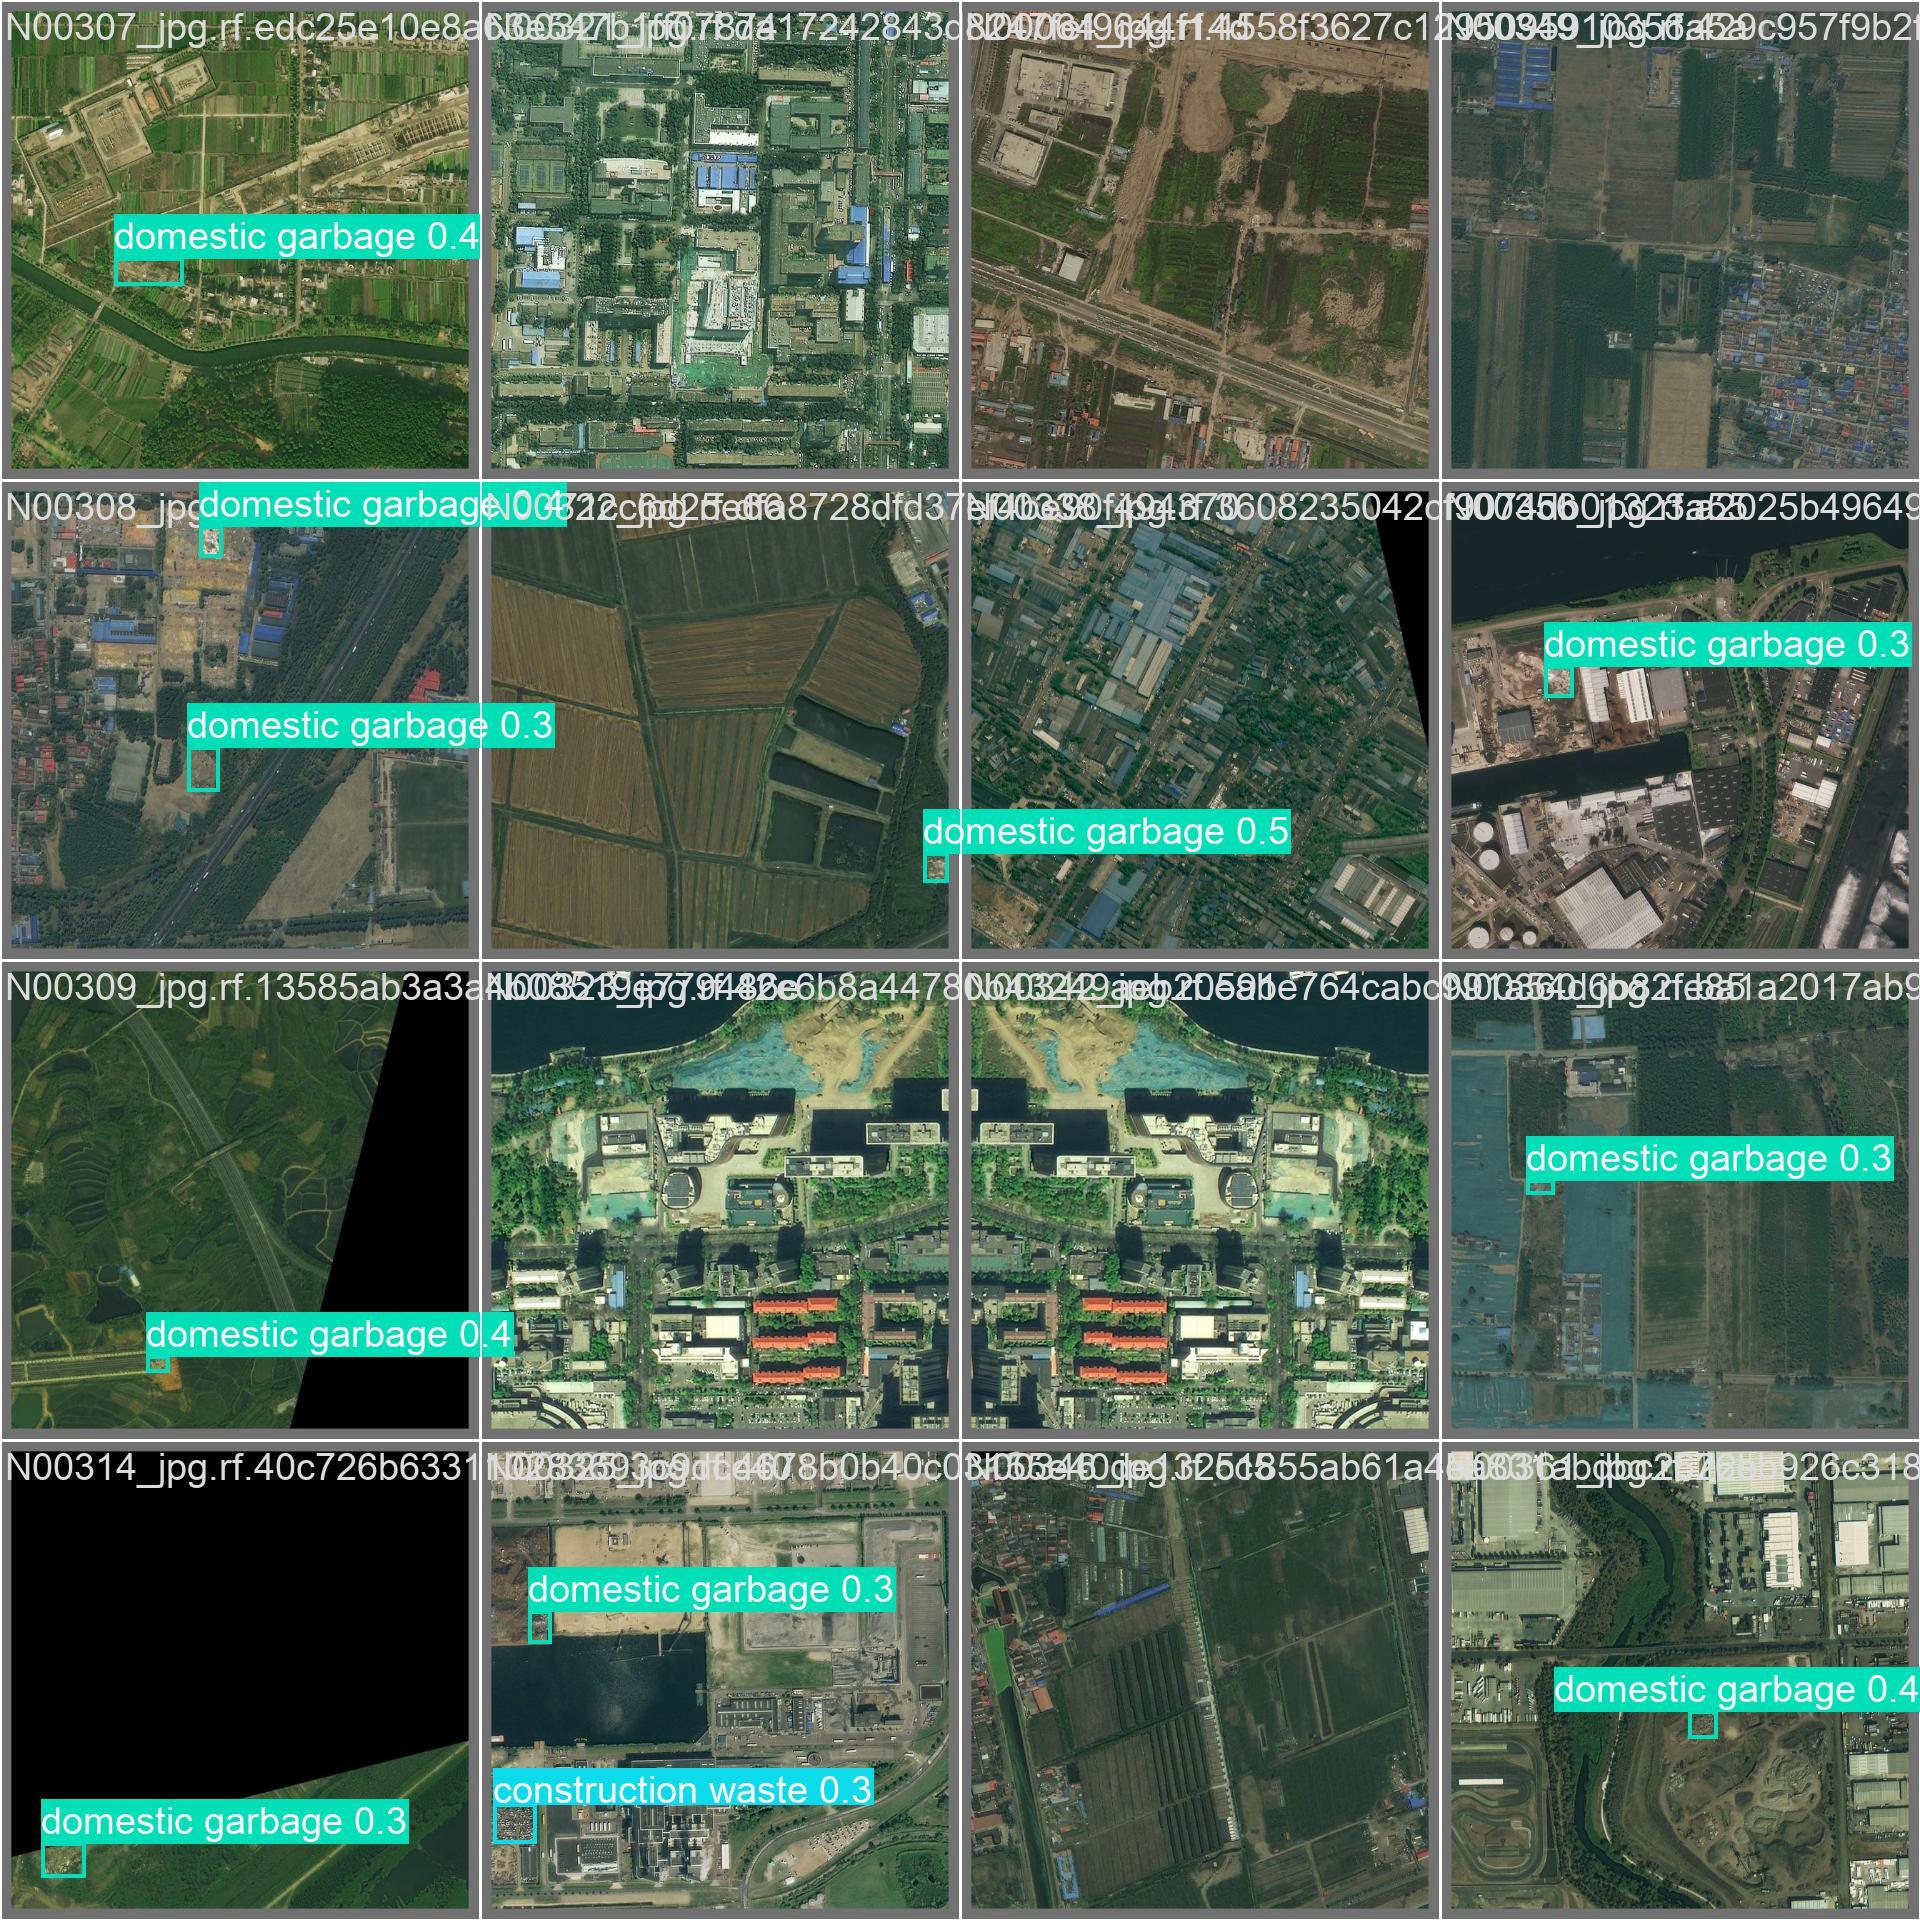
Figure4 validation batch2 prediction YOLOv8+CBAM:
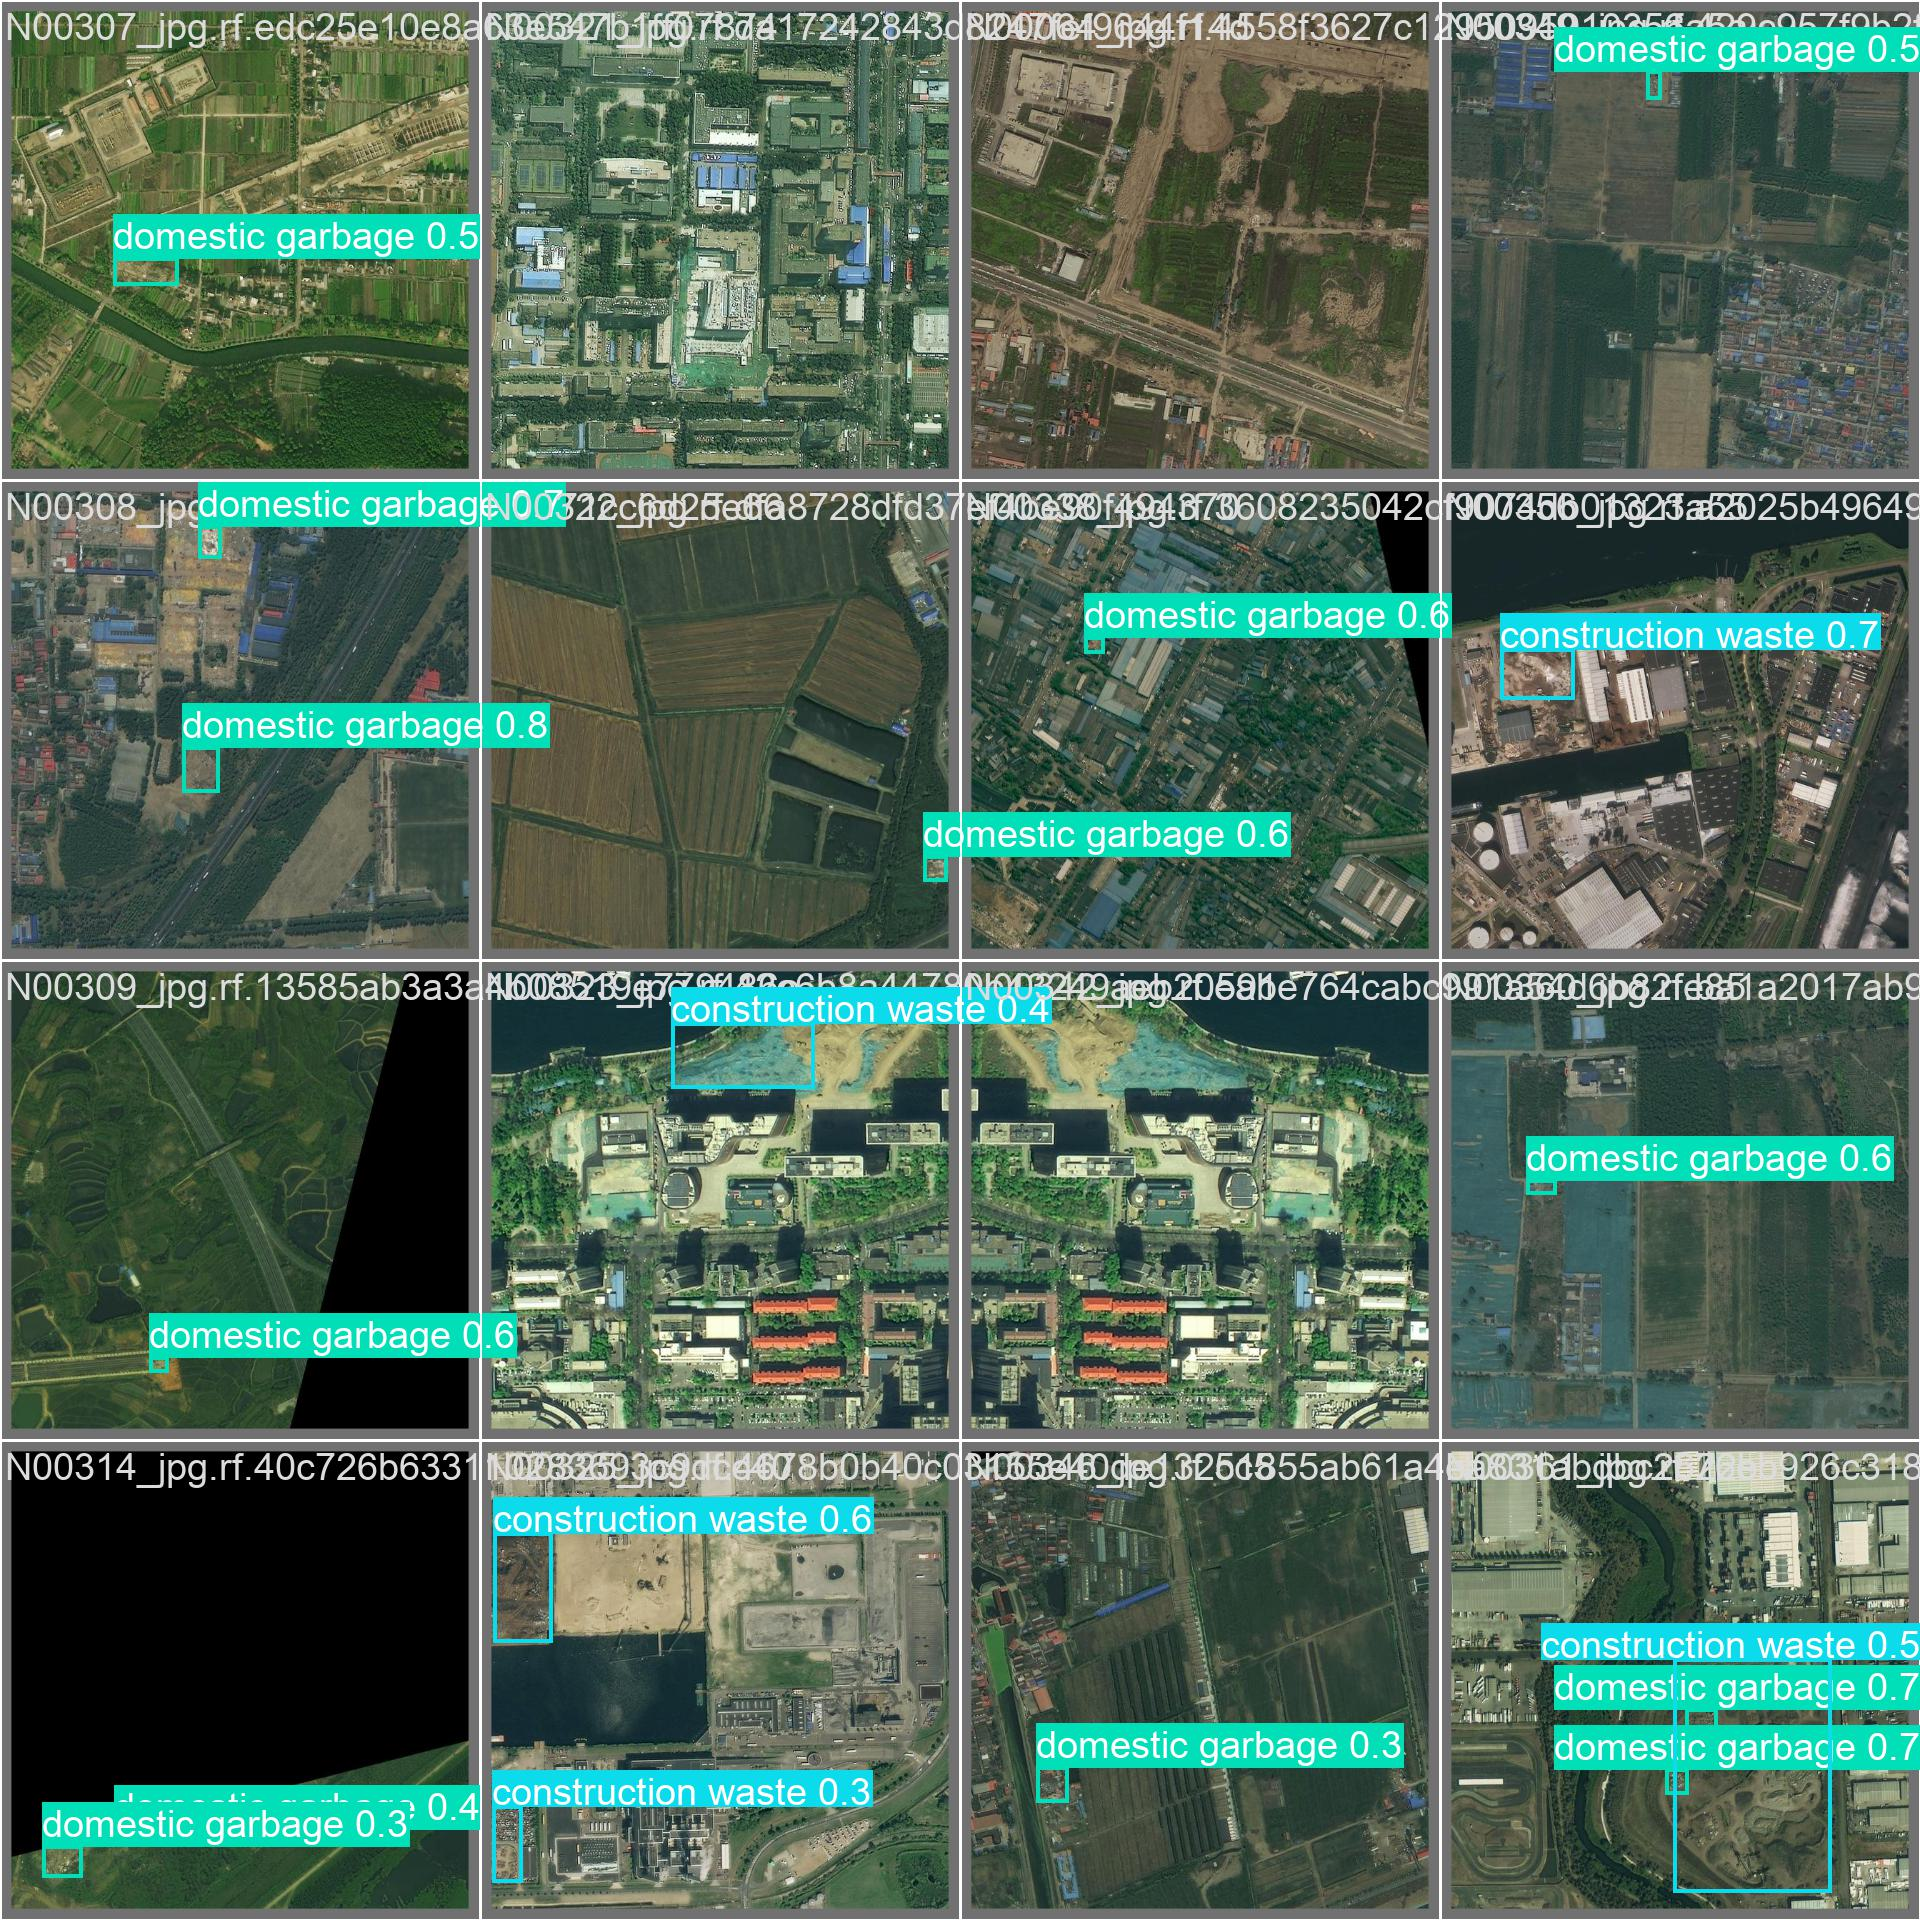
Figure5 matrics comparision of YOLOv8 and YOLOv8+CBAM:
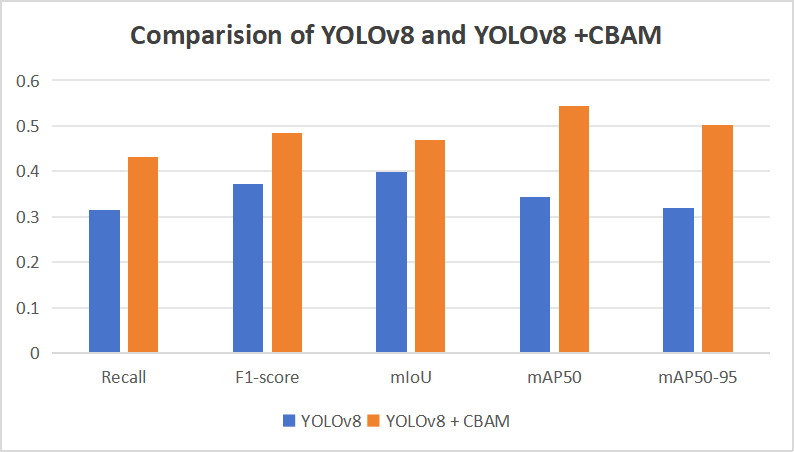

The model exhibits the following advantages with the addition of CBAM:
Better convergence of the loss function: the CBAM module enhances the model's attention to features, with less volatility in training and validation losses and faster convergence.
Improvement in precision and recall: CBAM improves the predictive ability of the model, especially in recall and mAP significantly better than the base YOLOv8.
Better stability of the model: the loss curve and performance index curve are smoother, indicating that the model is more stable and has enhanced generalization ability.
In summary, adding CBAM can effectively improve the performance and stability of the YOLOv8 model in the target detection task.

### 5.2 ResNet50-Faster-RCNN compare to ResNet101-Faster-RCNN 
From the results of ResNet50-Faster-R-CNN and yolov8, it can be seen that Faster-R-CNN is not very effective in processing satellite images, especially for small targets, the model has almost no correct recognition. The regression rate of this model is higher, but the IoU is lower.
The results of ResNet101-Faster-RCNN and ResNet50-Faster-R-CNN are not better. Most indicators are better for the model using the ResNet50 backbone network.

Figure6 reults in ResNet50-Faster-R-CNN:
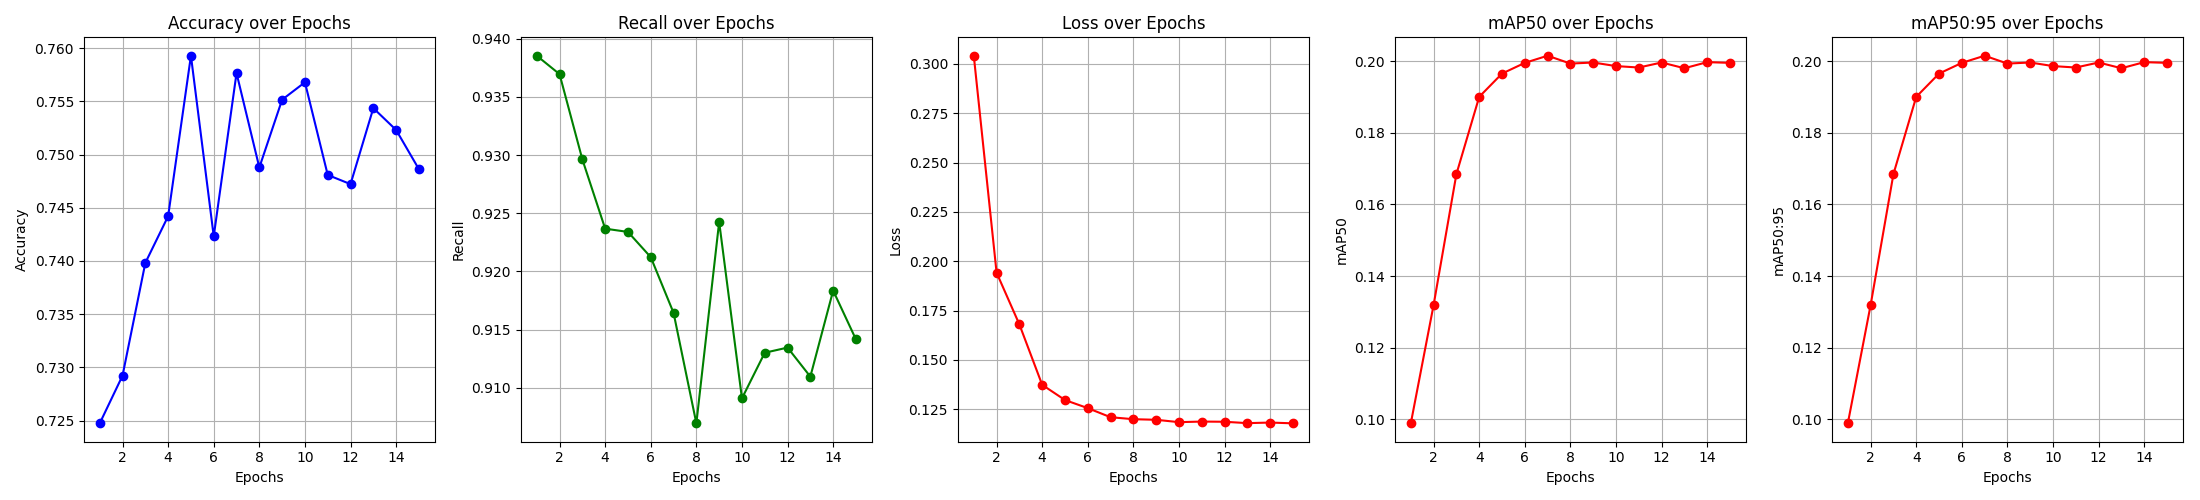
Figure7 reults in YOLOv8+CBAM:
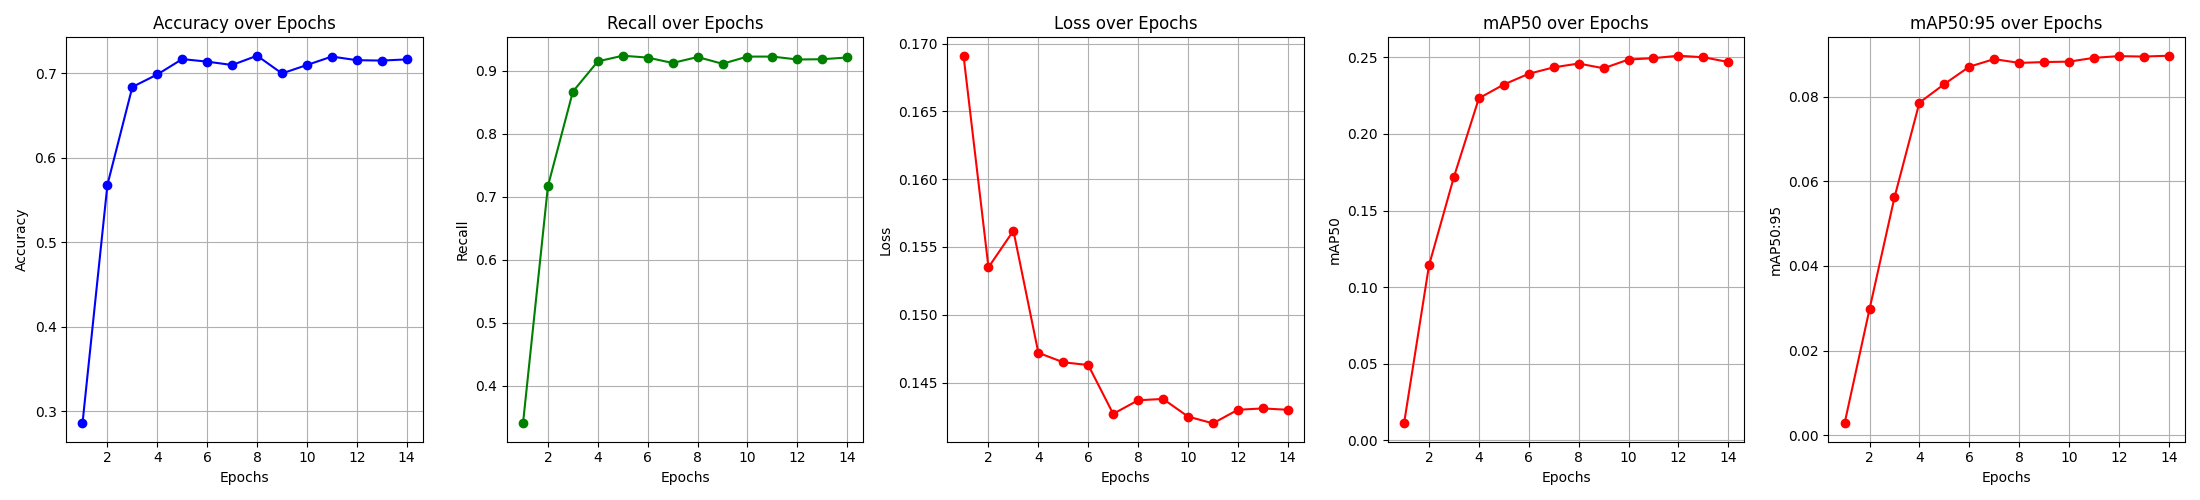
Figure8 validation prediction ResNet50-Faster-R-CNN:
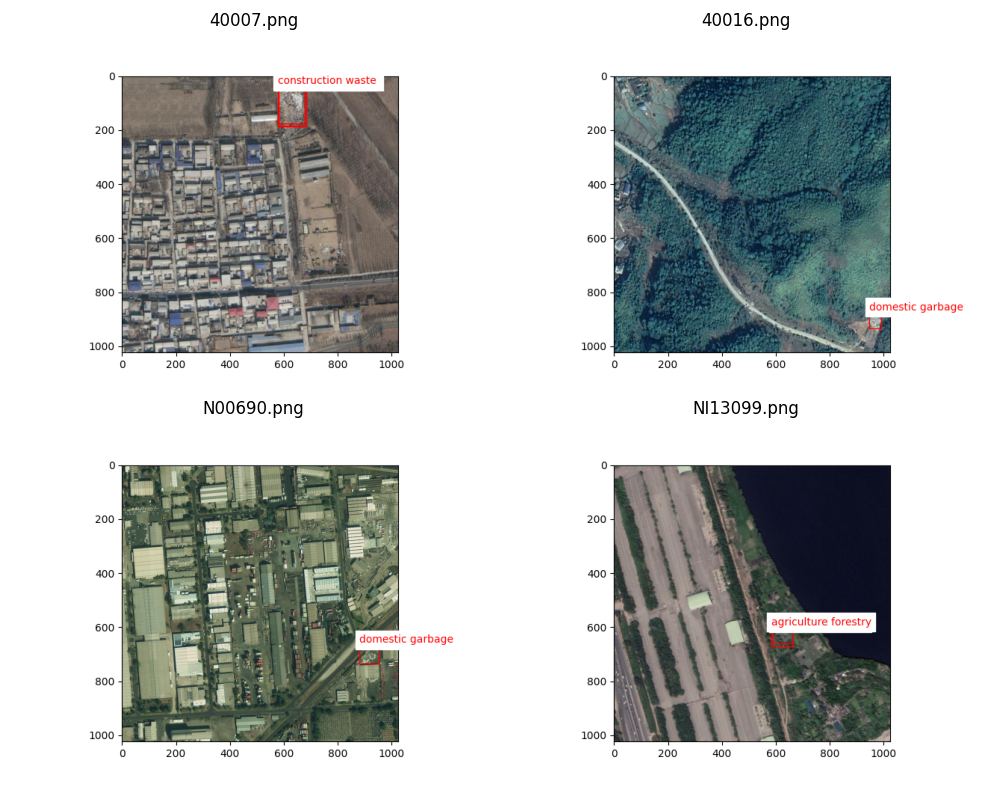
Figure9 validation batch2 prediction YOLOv8+CBAM:
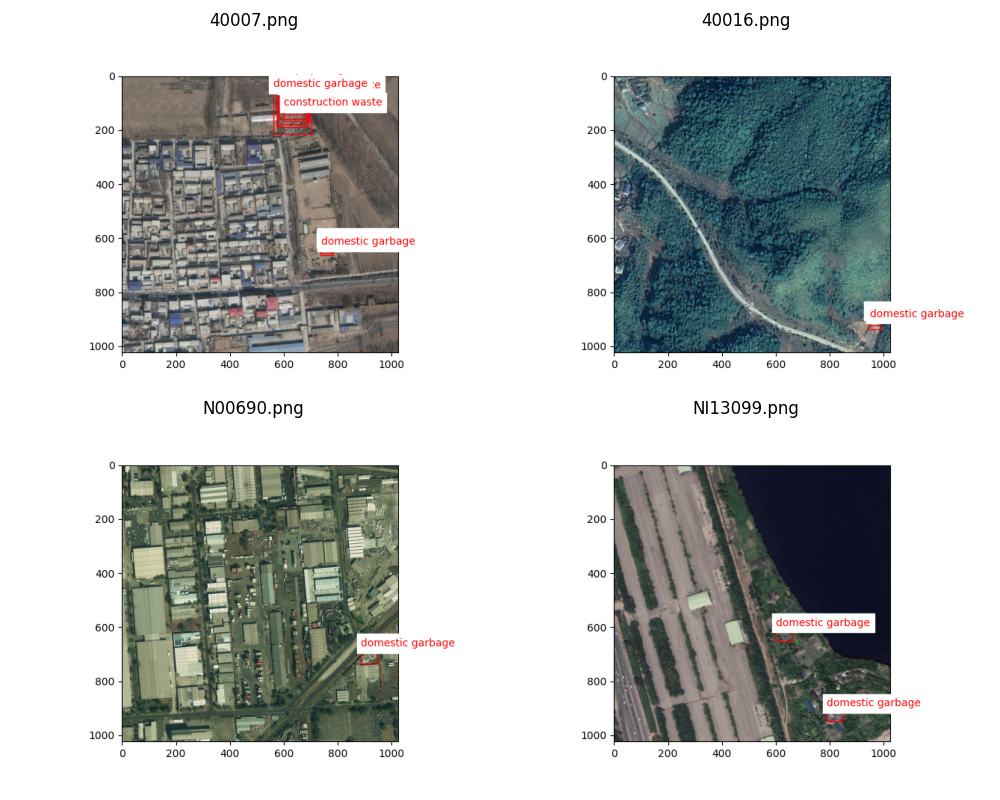
Figure10 matrics comparision of ResNet50-Faster-RCNN and ResNet101-Faster-RCNN 
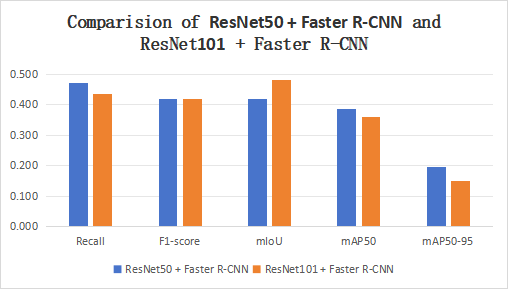



## 6. Discussion
Results and Analysis
YOLOv8+CBAM</br>
- Performance Improvements: The introduction of CBAM (Convolutional Block Attention Module) significantly enhances YOLOv8’s detection performance. Higher precision and recall suggest a reduction in false positives and false negatives, which leads to more reliable detection of objects. Additionally, the higher mAP50 and mAP50-95 metrics indicate that the model generalizes well to unseen data, which is crucial for robust real-world applications.
- Convergence and Training Stability: The loss curves show improved stability during training, with faster convergence rates. This suggests that CBAM helps the model focus more efficiently on relevant features, making the learning process more stable and efficient.
Faster-RCNN with ResNet101 vs. ResNet50:</br>
- Accuracy Differences: The performance of ResNet101 in Faster-RCNN is lower than that of ResNet50. One reason for this could be that deeper networks like ResNet101, while better at detecting large objects, struggle with small objects (common in satellite or garbage dump detection). Therefore, despite having more layers, ResNet101 may overfit or underperform on datasets with small, cluttered objects.
- Pretrained Weights Compatibility: Another possible explanation could be the pre-trained weights. ResNet50’s weights might align better with the specific characteristics of the dataset, leading to better performance. In contrast, ResNet101 might not transfer as effectively to this particular task, highlighting the importance of dataset-specific weight initialization.

2. System Performance Insights
- Strengths:

YOLOv8+CBAM:</br>
Enhanced feature focus improves accuracy and generalization.
Stable training with smoother loss curves.

Faster-RCNN with ResNet101 vs. ResNet50: </br>
Object Detection in Varied Scenarios: Even though the overall accuracy might be lower, Faster-RCNN, especially with ResNet50, can still be useful for detecting larger objects or when fewer false positives are required.

Effective for Manual Recognition: Faster-RCNN could also be more useful in situations where manual review of false positives and negatives is possible, as it can provide results even with lower accuracy.

- Weaknesses:
YOLOv8+CBAM:</br>
Increased computational cost due to extra parameters.
Effectiveness depends on attention quality in complex scenes.

Faster-RCNN (ResNet101):</br>
Overfitting and Inefficiency for Small Objects: Deeper networks like ResNet101 may have difficulty with smaller or more cluttered objects, leading to overfitting or poor generalization, especially on small datasets or those containing a lot of noise.

- Limitations:
YOLOv8+CBAM:</br>
Benefits vary across datasets.
Small sample classes (e.g., "mining waste") remain challenging.
Scalability concerns for larger models.

Faster-RCNN (ResNet101):</br>
Dataset Dependency: The performance difference between ResNet50 and ResNet101 highlights how pre-trained weights and dataset characteristics can significantly impact model performance. ResNet101 might not always perform optimally if the dataset contains a high proportion of small objects or clutter.

3. Future Work
YOLOv8+CBAM:</br>
- Optimize CBAM for efficiency and real-time applications.
- Improve data strategies for underrepresented classes.
- Test on diverse datasets and compare with other attention modules.
- Explore hybrid architectures with transformers for better performance.

Faster-RCNN (ResNet101):</br>
- Fine-Tuning Pre-trained Weights: Exploring different fine-tuning strategies for the pre-trained weights could help achieve better performance for specific tasks, especially for smaller or specialized objects.
- Dataset Augmentation: To better handle small objects or rare classes, more aggressive data augmentation strategies, such as synthetic data generation, could help address these shortcomings.
- Exploring Lighter Architectures: Future work could explore lighter versions of Faster-RCNN for smaller object detection tasks, balancing between model complexity and performance.

4. Conclusion
In conclusion, the integration of CBAM into YOLOv8 demonstrates significant performance improvements, particularly in precision, recall, and mAP. However, the increased computational burden and dependency on attention quality in complex scenes are notable limitations. On the other hand, Faster-RCNN with ResNet50, while lower in accuracy compared to ResNet101, remains competitive in scenarios where manual recognition is feasible and large objects are the focus. Both methods have their strengths, weaknesses, and limitations, and future work should focus on optimizing efficiency, improving dataset handling, and testing on broader datasets for better scalability and real-time use.